# Speech Reception Threshold (SRT) phenotype (quantitative)

## Aim

Create a dataset of filtered individuals using the inclusion and exclusion criteria for SRT phenotype to perform association analyses using the LMM.ipynb. 

## Location of files

In the shared folder is the original UKBB data
```
/SAY/dbgapstg/scratch/UKBiobank/phenotype_files/pleiotropy_R01/ukb42495_updatedJune2020
/SAY/dbgapstg/scratch/UKBiobank/phenotype_files/hearing_impairment
```

In my personal folder the filtered dataset

```
/home/dc2325/project/HI_UKBB
```

## Important phenotypic files

1. `200804_UKBB_HI_genotypeqc.csv` File containing all individuals that passed QC and hearing impairment variables
2. `200804_UKBB_HI_genotypeqc_excr.csv` File with applied exclusion criteria as indicated [here](https://docs.google.com/document/d/1cpxTzElpsEkwmBDjnMBHg2wW7CL1AcG_b0_0wE_k5rQ/edit). **Note**: this file excludes individuals with otosclerosis, Meniere's and other diseases, if you need to filter those particular phenotypes use file 1 instead.
3. `200811_UKBB_Tinnitus_plan1_2_3_f4803` File with filtered phenotypes for tinnitus plan 1,2 and 3 and imputed noise variables
4. `200814_UKBB_HI_genotypeqc_excr_impvars` Database with qc'ed individuals, exclusion criteria, noise imputed vars and tinnitus phenotypes
5. `200819_UKBB_SRT_f.20019&f.20021` SRT inverse normalized for left, right, best and worst ear and dichotomous trait (cases top 25% - controls bottom 25%)

## SRT analysis plan

**The phenotypes to be used are as follow:**
1. Left ear f.20019
2. Right ear f.20021
3. Best ear (create a new variable extracting the min SRT value among f.20019 and f.20021)
4. Worst ear (create a new variable extracting the max SRT value among f.20019 and f.20021)
5. Dichotomous trait: 
- controls are those at the bottom 25% for left ear (< -7.5) and right ear (< -7.5)
- cases are those at the top 25% for left (>-5) and right ear (>-5)

**Age is calculated as follows:**

- For people with repeated measures take age at last visit and measurement at last visit
- For people with only one measure take age at that visit

**Sex corresponds to f.22001 (genetic sex):**

- Male = 0
- Female = 1

**Noisy workplace and loud music exposure frequency: same as for Tinnitus**
                
1. Remove inconsistent individuals 
    - said 1,2 or 3 and in following visits said 0
    - said a higher exposure (e.g 3) and then a lower one (e.g 1 or 2) in following visits
2. Retain consistent individuals and use highest reported exposure

**The needs to be inverse normalized**

**Covariates to be included in the analysis include:**

1. Age at time of test (calculated from f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0)
2. Sex f.22001
3. Volume left ear f.4270 and right ear f.4277 (The volume set by the participant for the measurement which you are using in the analysis ir our case the last time they took the test). For the analysis we use the average of the right and left ear since there is overlap in the volume distribution
4. Noisy workplace f.4825
5. Loud music exposure f.4836

## Load libraries and set working dir

In [ ]:
#Load libraries
library(plyr)
library(tidyverse)
library(pander)
library(ggpubr)
library(rapportools)
library(ggplot2)
#Get working directory
getwd()

In [2]:
#Set working directory
setwd('~/project/HI_UKBB')

## Clean workspace

In [15]:
# Clean workspace
rm(list=ls())

## Filter SRT codes

* Obtain scores for right and left ear
* Obtain the age at the last visit

In [16]:
df.final.imp = read.csv('200814_UKBB_HI_genotypeqc_excr_impvars.csv')

In [20]:
head(df.final.imp)

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.41281.0.45,f.41281.0.46,age,tinnitus,tinnitus_p2,tinnitus_p3,noise_wp,loud_music,noise_imp,music_imp
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1000022,1000022,0,0,1,-9,Male,1954,2008-01-22,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,NA,73,0,0,0,0,0,0,0
5,1000054,1000054,0,0,2,-9,Female,1942,2007-11-23,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,NA,43,0,0,0,0,0,0,0


In [21]:
#extract the SRT score for left ear and right ear at the last visit for repeaters 

srt_all = df.final.imp %>% 
  select(IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0, f.20019.0.0, f.20019.1.0, f.20019.2.0, f.20019.3.0,f.20021.0.0,f.20021.1.0,f.20021.2.0,f.20021.3.0,f.4270.0.0,f.4270.1.0,f.4270.2.0,f.4270.3.0,f.4277.0.0,f.4277.1.0,f.4277.2.0,f.4277.3.0,
        f.4825.0.0, f.4825.1.0, f.4825.2.0, f.4825.3.0,f.4836.0.0, f.4836.1.0, f.4836.2.0, f.4836.3.0)


srt_clean <-  srt_all %>% 
  mutate(srt_score_left = apply(select(., starts_with("f.20019")), 1, function(x)  {tail(x[!is.na(x)],n=1)[1]}),
         srt_score_right = apply(select(., starts_with("f.20021")), 1, function(x) {tail(x[!is.na(x)],n=1)[1]}),
         srt_age =  apply(select(., starts_with("f.21003")), 1, function(x)  {tail(x[!is.na(x)],n=1)[1]}),
         left_volume =  apply(select(., starts_with("f.4270")), 1, function(x)  {tail(x[!is.na(x)],n=1)[1]}),
         right_volume =  apply(select(., starts_with("f.4277")), 1, function(x)  {tail(x[!is.na(x)],n=1)[1]})
  ) 

In [22]:
head(srt_clean)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,f.4825.3.0,f.4836.0.0,f.4836.1.0,f.4836.2.0,f.4836.3.0,srt_score_left,srt_score_right,srt_age,left_volume,right_volume
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,1000019,1000019,Female,47,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,47,NA,NA
2,1000022,1000022,Male,53,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,53,NA,NA
3,1000035,1000035,Male,63,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,63,NA,NA
4,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,NA,NA,NA,No,NA,-6.0,-5,73,70%,40%
5,1000054,1000054,Female,65,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,65,NA,NA
6,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,NA,No,NA,NA,NA,-8.5,-7,43,40%,100% (max)


##  Recode noisy workplace f.4825 and loud music frequency exposure f.4836

In [23]:
# Recode function:
recode_ordinal<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= "0", 
                                            "Yes, for less than a year"= "1", 
                                            "Yes, for around 1-5 years"= "2", 
                                            "Yes, for more than 5 years"= "3",
                                            "Prefer not to answer"= NA,
                                            "Do not know"= NA ))
    df[,new_column_name] <- ordered(df[,new_column_name] , c("0", "1", "2", "3"))
  }
  return (list(df=df,new_column_names=new_names))
}
# columns needs to be recoded:
column_name<-c("f.4825.0.0", "f.4825.1.0", "f.4825.2.0", "f.4825.3.0","f.4836.0.0", "f.4836.1.0", "f.4836.2.0", "f.4836.3.0")
# get a new data.frame with recoded columns added:
srt_clean<-recode_ordinal(df=srt_clean,column_name)$df
# get names of recoded columns:
new_column_names<-recode_ordinal(df=srt_clean,column_name)$new_column_names
# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(srt_clean[,i]));cat("\n")}

f.4825.0.0_recode summary:
    0     1     2     3 
87528  6234  6640 14264 

f.4825.1.0_recode summary:
    0     1     2     3 
12149   801   783  1525 

f.4825.2.0_recode summary:
    0     1     2     3 
28551  1742  1759  3451 

f.4825.3.0_recode summary:
   0    1    2    3 
1935  129  108  220 

f.4836.0.0_recode summary:
     0      1      2      3 
100440   3440   5336   4877 

f.4836.1.0_recode summary:
    0     1     2     3 
13681   361   585   532 

f.4836.2.0_recode summary:
    0     1     2     3 
31507   923  1445  1386 

f.4836.3.0_recode summary:
   0    1    2    3 
2116   67  111   82 



## Checking consistency of the f.4825 noisy workplace and filtering

In [24]:
# Extract subset of data only with the recode columns of noisy workplace variable
data_noise <- srt_clean %>%
  select(IID, "f.4825.0.0_recode", "f.4825.1.0_recode", "f.4825.2.0_recode", "f.4825.3.0_recode")  
dim(data_noise)

[1] 354347      5

In [25]:
# Function to extract all the available answers for 4 visits
# and put them in one list
f<-function(x){
  visit<-c()
  for (i in 2:5){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=as.numeric(visit)}
  return (visit)
}

# Apply the above function and remove NAs
data_noise$visit<-apply(data_noise, 1, f)

In [26]:
data_noise<-data_noise %>%
  filter(!is.na(visit)) 
head(data_noise)
dim(data_noise)

,IID,f.4825.0.0_recode,f.4825.1.0_recode,f.4825.2.0_recode,f.4825.3.0_recode,visit
,<int>,<ord>,<ord>,<ord>,<ord>,<list>
1,1000046,NA,NA,0,NA,0
2,1000063,0,NA,NA,NA,0
3,1000078,NA,0,0,NA,"0, 0"
4,1000105,0,NA,NA,NA,0
5,1000112,NA,NA,0,NA,0
6,1000141,0,NA,NA,NA,0


[1] 145367      6

In [27]:
# Function to get the final code for noise_wp
f<-function(x){
  l=length(x$visit)
  if (l==1){ # only one answer available
    result=x$visit
  }
  else{ # more then one answer available
    result=x$visit[1]
    for (i in 2:l){
      if (x$visit[i] >= x$visit[i-1]){result=x$visit[i]} # consistent ones
      else {result=NA; break} # inconsistent ones
    }
  }
  return(result)
}

# Apply the above function and remove NAs
data_noise$noise_wp<-apply(data_noise, 1, f)
data_noise<-data_noise %>%
  filter(!is.na(noise_wp)) 
head(data_noise, 12) # note: noise_wp code generated here is numeric, not factor
dim(data_noise)

,IID,f.4825.0.0_recode,f.4825.1.0_recode,f.4825.2.0_recode,f.4825.3.0_recode,visit,noise_wp
,<int>,<ord>,<ord>,<ord>,<ord>,<list>,<dbl>
1,1000046,NA,NA,0,NA,0,0
2,1000063,0,NA,NA,NA,0,0
3,1000078,NA,0,0,NA,"0, 0",0
4,1000105,0,NA,NA,NA,0,0
5,1000112,NA,NA,0,NA,0,0
6,1000141,0,NA,NA,NA,0,0
7,1000236,0,NA,0,NA,"0, 0",0
8,1000248,3,NA,NA,NA,3,3
9,1000269,NA,NA,0,NA,0,0


[1] 143989      7

In [29]:
# Append the noise variable to the data
df.noise = merge(x = srt_clean,y = data_noise[,c("IID", "noise_wp")],by="IID", all.x=TRUE)
dim(df.noise)

[1] 354347     45

## Checking consistency of the f.4836 loud music exposure frequency and filtering

In [30]:
# Extract subset of data only with the recode columns of loud music exposure variable f.4836
data_music <-  srt_clean %>%
  select(IID,f.4836.0.0_recode,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode) 
head(data_music)
dim(data_music)

,IID,f.4836.0.0_recode,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode
,<int>,<ord>,<ord>,<ord>,<ord>
1,1000019,NA,NA,NA,NA
2,1000022,NA,NA,NA,NA
3,1000035,NA,NA,NA,NA
4,1000046,NA,NA,0,NA
5,1000054,NA,NA,NA,NA
6,1000063,0,NA,NA,NA


[1] 354347      5

In [31]:
# Function to extract all the available answers for 4 visits
# and put them in one list

f<-function(x){
  visit<-c()
  for (i in 2:5){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=as.numeric(visit)}
  return (visit)
}

# Apply the above function and remove NAs
                              
data_music$visit<-apply(data_music, 1, f)
data_music<-data_music %>%
  filter(!is.na(visit)) 
head(data_music)
dim(data_music)

,IID,f.4836.0.0_recode,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode,visit
,<int>,<ord>,<ord>,<ord>,<ord>,<list>
1,1000046,NA,NA,0,NA,0
2,1000063,0,NA,NA,NA,0
3,1000078,NA,0,0,NA,"0, 0"
4,1000105,0,NA,NA,NA,0
5,1000112,NA,NA,0,NA,0
6,1000141,0,NA,NA,NA,0


[1] 144706      6

In [32]:
# Function to get the final code for "loud_music"
f<-function(x){
  l=length(x$visit)
  if (l==1){ # only one answer available
    result=x$visit
  }
  else{ # more then one answer available
    result=x$visit[1]
    for (i in 2:l){
      if (x$visit[i] >= x$visit[i-1]){result=x$visit[i]} # consistent ones
      else {result=NA; break} # inconsistent ones
    }
  }
  return(result)
}

# Apply the above function and remove NAs
data_music$loud_music<-apply(data_music, 1, f)
data_music<-data_music %>%
  filter(!is.na(loud_music)) 
head(data_music, 12) # note: loud_music code generated here is numeric, not factor
dim(data_music)

,IID,f.4836.0.0_recode,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode,visit,loud_music
,<int>,<ord>,<ord>,<ord>,<ord>,<list>,<dbl>
1,1000046,NA,NA,0,NA,0,0
2,1000063,0,NA,NA,NA,0,0
3,1000078,NA,0,0,NA,"0, 0",0
4,1000105,0,NA,NA,NA,0,0
5,1000112,NA,NA,0,NA,0,0
6,1000141,0,NA,NA,NA,0,0
7,1000236,0,NA,0,NA,"0, 0",0
8,1000248,0,NA,NA,NA,0,0
9,1000269,NA,NA,0,NA,0,0


[1] 143309      7

In [33]:
# Merge all of the variables in the final dataset
df.noise.vars = merge(x = df.noise,y = data_music[,c("IID", "loud_music")],by="IID", all.x=TRUE)
dim(df.noise.vars) 

[1] 354347     46

## Imputation of noise variables using the median

## Number of individuals with SRT for left and right ear

In [36]:
#NA for both ear (211763 individuals)
srt_NA <- df.noise.vars %>% 
  filter(is.na(srt_score_left) & is.na(srt_score_right))
cat("There are",nrow(srt_NA)," individuals with missing data for both ears.\n")

There are 211763  individuals with missing data for both ears.


In [37]:
#all people who have left ear score  141029
left_ear <- df.noise.vars %>% 
  filter(!is.na(srt_score_left))
cat("There are",nrow(left_ear)," individuals with SRT score for the left ear.\n")

There are 141029  individuals with SRT score for the left ear.


In [46]:
length(which(is.na(left_ear$noise_wp)))
length(which(is.na(left_ear$loud_music)))

[1] 2351

[1] 3025

In [38]:
#all people who have right ear score  141030 
right_ear <- df.noise.vars %>% 
  filter(!is.na(srt_score_right))
cat("There are",nrow(right_ear)," individuals with SRT score for the right ear.\n")

There are 141030  individuals with SRT score for the right ear.


In [47]:
length(which(is.na(right_ear$noise_wp)))
length(which(is.na(right_ear$loud_music)))

[1] 2347

[1] 3032

In [39]:
#1555 who have srt score for right ear but not for left ear
right_ear_na <- df.noise.vars %>% 
  filter(!is.na(srt_score_right) & is.na(srt_score_left))
cat("There are",nrow(right_ear_na)," individuals with SRT score for the right ear but not for the left ear.\n")

There are 1555  individuals with SRT score for the right ear but not for the left ear.


In [40]:
#1554 who have srt score for left ear but not for right ear
left_ear_na <- df.noise.vars %>% 
  filter(!is.na(srt_score_left) & is.na(srt_score_right))
cat("There are",nrow(left_ear_na)," individuals with SRT for left ear but not for right ear.\n")

There are 1554  individuals with SRT for left ear but not for right ear.


In [41]:
#139475 have SRT score for both ears
both_ear <- df.noise.vars %>% 
   filter(!is.na(srt_score_left) & !is.na(srt_score_right))
cat("There are",nrow(both_ear)," individuals with SRT score for both ears.\n")

There are 139475  individuals with SRT score for both ears.


In [48]:
length(which(is.na(both_ear$noise_wp)))
length(which(is.na(both_ear$loud_music)))

[1] 2328

[1] 2998

In [42]:
#142584 have SRT score for either ear 
either_ear <- df.noise.vars %>% 
   filter(!is.na(srt_score_left) | !is.na(srt_score_right))
cat("There are",nrow(either_ear)," individuals with SRT score for either left or right ears.\n")

There are 142584  individuals with SRT score for either left or right ears.


In [43]:
dim(df.noise.vars)

[1] 354347     46

## SRT score as categorical variable

In [52]:
### Classification for SRT Score 
#create a categorical variable to classify the score for left and right ear
#138901 have either right or left score, or both  (deleting the outliers #remove the score 8 (outlier) for both ears)
srt_cat <- df.noise.vars %>% 
    mutate(srt_score_left = ifelse(srt_score_left == 8, NA, srt_score_left),
           srt_score_right = ifelse(srt_score_right == 8, NA, srt_score_right)) %>%
    filter(!is.na(srt_score_left) | !is.na(srt_score_right)) %>% 
    mutate(srt_left_cat = case_when(
        srt_score_left < -5.5   ~  "normal",
        -5.5 <= srt_score_left & srt_score_left <= -3.5   ~  "insufficient",
          srt_score_left > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  mutate(srt_right_cat = case_when(
        srt_score_right < -5.5   ~  "normal",
        -5.5 <= srt_score_right & srt_score_right <= -3.5   ~  "insufficient",
          srt_score_right > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) 

nrow(srt_cat)

[1] 142375

In [53]:
#to use the function max/min, replace all NA to -99 for numerical variables 
srt_fill_na <- srt_cat
srt_fill_na$srt_score_left %>% replace_na(-99)
srt_fill_na$srt_score_right %>% replace_na(-99)

[1]  -6.00  -8.50  -4.00  -7.50  -4.00  -6.50  -8.50 -99.00  -4.50 -99.00
   [11]  -6.50 -99.00  -8.50  -5.50  -6.50  -7.00  -6.00  -7.50  -6.00  -8.50
   [21]  -8.00  -5.50  -7.00  -5.50  -9.50  -6.00  -8.00  -8.00  -8.00  -6.50
   [31]  -9.00  -8.00  -4.50  -5.50  -4.50  -6.50  -4.50  -8.50  -5.00  -4.00
   [41]  -8.00  -1.00  -6.00  -5.00  -7.00  -3.50  -5.50  -8.00  -9.50  -9.00
   [51]  -8.50  -5.50  -8.50  -3.50  -6.00  -7.00  -5.50  -6.00  -5.00  -6.50
   [61]  -5.50  -7.50  -5.00  -4.00 -10.00  -3.00  -7.00  -8.00  -5.50  -9.00
   [71]  -7.50  -7.50  -5.50  -7.00  -7.50  -8.00  -4.50  -5.00  -7.00   0.50
   [81]  -6.50  -7.00  -4.00  -5.00   7.50  -7.00  -6.50  -7.50  -6.00  -6.50
   [91]  -4.50  -8.00 -99.00  -5.50  -6.00  -5.50  -9.50  -5.00  -5.50  -8.00
  [101]  -3.00  -5.00  -6.00  -9.00  -6.00  -7.00  -6.50  -9.00  -8.50  -7.50
  [111]  -6.50 -99.00  -4.50  -8.00  -2.00  -7.00  -7.00  -8.00  -8.50  -7.00
  [121]  -5.50  -5.50  -6.50  -8.00  -5.00  -8.00  -4.50  -7.00  -7.00  -7.50
  [131]  -7.50  -6.50  -9.00  -8.50  -7.50  -5.00  -9.50  -6.00  -8.50  -4.00
  [141]  -8.00  -6.50  -8.50  -7.00  -5.50  -8.00  -5.50  -5.50  -5.50  -3.00
  [151]  -2.50  -7.00  -7.00  -5.50  -4.00  -5.50  -6.00  -8.50  -8.00  -7.50
  [161]  -5.50  -7.50  -5.50  -9.00  -7.00  -6.50  -5.50  -9.00 -99.00  -3.50
  [171]  -4.50  -8.50  -5.50  -6.00  -7.50  -4.00  -5.50  -8.00  -8.00  -7.00
  [181]  -2.00  -7.50  -8.00  -3.50  -6.00  -7.00  -7.00  -7.50 -99.00  -8.00
  [191]  -8.50  -6.00  -7.00  -6.50  -7.00  -7.50  -5.00  -6.50  -5.50  -6.00
  [201]  -9.00  -7.50  -6.50  -2.00  -4.50  -6.00  -4.00  -5.50  -8.00  -7.00
  [211]  -8.00  -6.00  -4.50  -8.00  -6.00  -7.00  -6.50  -8.50  -8.00  -5.00
  [221]  -6.50  -4.00  -3.00  -7.00  -8.00  -7.00  -9.00  -7.00  -6.00  -5.00
  [231]  -5.50  -6.50  -7.50  -7.50  -5.50  -7.50  -8.00  -7.00  -8.00  -5.50
  [241]  -5.50  -9.25  -7.00  -5.00 -99.00  -5.50  -7.00  -5.50  -3.00  -7.50
  [251]  -7.00  -7.50   4.50  -6.50  -8.00  -8.00  -5.50  -0.50  -6.00  -6.50
  [261]  -6.50  -4.50  -7.00  -3.50  -6.50  -8.50  -5.50  -8.50  -5.50  -9.00
  [271]  -5.50  -3.50  -9.00  -8.00  -6.00  -7.50  -9.00  -2.50  -7.00  -8.00
  [281]  -6.00  -5.50  -8.00  -7.00  -6.50 -99.00  -7.50  -8.50  -8.50  -7.50
  [291] -10.00  -6.50  -4.00  -5.50  -4.00  -7.50  -8.50  -3.50  -8.50  -5.50
  [301]  -8.00  -6.00  -6.50  -7.50  -6.50  -4.00  -7.00  -5.00  -7.50  -9.00
  [311]  -8.00  -3.00  -8.00  -6.50  -6.50  -6.00   3.00   0.50  -8.50  -5.00
  [321]   4.25  -8.50   4.50  -8.00  -6.00  -8.00  -8.00  -7.50  -8.00  -5.00
  [331]  -5.00  -6.50  -6.00  -4.00  -5.50 -10.00  -8.50  -5.00  -7.00  -7.50
  [341]  -7.00  -8.00  -3.50  -6.00  -7.00  -9.50  -6.50  -5.00  -4.00  -7.50
  [351] -10.50  -6.00  -5.50  -6.00   2.00  -8.00  -4.50  -7.00  -7.50  -6.50
  [361] -10.00  -6.50  -6.00  -6.00  -7.00  -8.50  -4.50  -6.50  -9.50  -8.50
  [371]  -7.50  -5.50  -5.00  -5.50  -5.00  -4.00  -9.00  -8.00  -7.00 -99.00
  [381]  -6.00  -5.00  -6.00  -2.00  -7.00  -5.50  -6.00  -7.00  -8.00  -2.50
  [391]  -9.00  -8.00 -99.00  -6.00  -6.00  -7.00  -6.00  -6.00  -7.50  -5.00
  [401]  -2.00   0.00 -99.00  -7.00  -8.00  -5.50  -6.50  -7.50  -4.50  -7.50
  [411]  -8.00  -6.00  -7.00  -7.50  -9.50  -7.50  -7.00  -7.50  -4.50  -8.00
  [421]  -6.00  -4.50  -5.50  -4.00  -7.00  -8.50  -5.00  -7.50  -7.00  -5.50
  [431]  -5.00  -4.00  -4.00  -2.00  -8.50  -6.00  -2.50  -4.50  -7.00  -4.00
  [441]  -7.00  -9.50  -2.00  -3.00  -6.00  -4.00  -4.00  -8.00  -5.50  -4.00
  [451]  -6.50  -3.50  -4.00  -8.50  -6.00  -7.00  -5.50  -7.50  -4.00  -7.50
  [461]  -9.00  -6.00  -5.50 -10.00  -4.50  -4.00  -4.00  -6.50  -3.50  -7.50
  [471]  -7.00  -5.00  -6.00  -5.00  -8.00  -4.50  -6.50  -5.50  -7.50  -8.00
  [481]  -4.50  -5.00  -8.00  -5.50  -4.50  -7.00  -8.00  -3.50  -7.00  -4.00
  [491]  -7.00  -7.00  -9.50  -7.00  -5.50  -2.50  -8.00  -6.00  -7.50  -7.00
  [501]  -9.50  -1.50  -6.50  -5.00  -7.00  -4.00  -4.50  -8.50   0.50  -6.00
  [511]  -7.50  -9.00  -9.

[1]  -5.00  -7.00  -5.00  -6.50  -4.00  -7.50  -2.50  -3.50  -6.00  -4.00
   [11]  -5.00  -9.00  -8.00  -7.00  -6.50  -8.00  -6.00  -9.00  -7.00  -6.00
   [21]  -6.00  -8.00  -7.00  -8.50  -8.00  -5.50  -8.00  -4.50  -5.50  -7.50
   [31]  -7.50  -7.00  -5.50  -6.00  -5.00  -6.00  -6.00  -7.00  -4.00   1.50
   [41]  -8.50  -7.00  -5.50  -4.50  -9.00  -6.50  -7.50  -5.00  -6.00  -8.50
   [51]  -7.50  -7.50  -8.00  -6.00  -7.50  -7.50  -2.00  -4.00  -5.50  -6.00
   [61]  -7.50  -8.00  -7.00  -6.00  -6.50   0.00  -7.00  -9.50  -4.50  -7.50
   [71]  -7.50  -7.00  -4.00  -7.50  -7.50  -5.50  -4.00  -7.00  -8.00   6.75
   [81]  -3.50  -9.00  -7.50  -8.00  -8.00  -6.50  -6.00  -8.50  -4.00  -6.00
   [91]  -3.00  -4.50   7.50  -3.00  -2.50  -3.00  -6.50  -3.50  -4.50  -5.50
  [101]  -7.00  -7.00  -7.50  -8.00  -6.50  -9.00  -5.50  -7.00  -7.00  -7.00
  [111]  -3.00  -6.00  -6.00  -9.00  -6.00  -2.50  -7.50  -8.00  -4.50  -8.00
  [121]  -8.00  -6.50  -7.00  -6.00  -1.00  -7.50  -6.50  -7.50  -4.50  -8.00
  [131]  -6.50  -6.00  -7.50  -8.50  -7.00  -6.00  -6.50  -7.50  -7.50  -6.50
  [141]  -6.50  -3.50  -7.00  -7.00  -5.50  -8.00  -5.00  -6.00 -99.00  -4.50
  [151]  -4.00  -6.50  -5.50  -8.00  -5.50  -9.50  -8.00  -7.00  -7.50 -99.00
  [161] -10.00  -8.00  -7.50  -9.00  -8.50  -9.00  -5.50  -8.50  -5.50   7.50
  [171]  -7.50  -6.50  -5.00  -7.00  -4.50  -6.50  -6.50  -6.50 -99.00  -6.50
  [181]  -5.00  -5.00  -7.00  -3.50  -7.50  -6.00  -6.50  -9.00  -1.00  -5.50
  [191]  -9.00  -5.50  -7.00  -8.50  -6.00  -6.00  -4.50  -4.00  -4.00  -7.00
  [201]  -8.00  -4.00  -5.50   0.00  -2.50  -6.50  -7.50  -8.00  -9.00  -9.00
  [211]  -6.50  -5.00  -7.50  -1.00  -7.00  -5.00  -8.50  -7.00  -5.50  -7.00
  [221]  -8.00  -7.00  -5.00  -1.50  -7.00  -4.50  -9.00  -7.50  -6.00  -2.50
  [231]  -3.50  -7.50  -6.50  -6.00  -4.50  -7.50  -4.00  -9.50  -6.50  -3.50
  [241]  -9.00  -8.00  -5.50  -6.00  -6.00  -8.00  -9.00  -4.50  -4.50  -8.00
  [251]  -6.50  -6.00  -5.50  -0.50  -8.00  -8.50  -7.00  -6.00  -4.50  -8.00
  [261]  -4.00  -3.50  -6.50  -4.00  -7.50  -6.00  -7.00  -5.00  -5.50  -8.00
  [271]  -1.00  -3.50  -8.00  -8.00  -7.00  -7.50  -5.50  -0.50  -6.50  -6.00
  [281]  -5.00  -2.50  -5.00  -6.00  -4.50  -4.00  -7.00  -7.00  -9.50  -6.50
  [291]  -7.00  -7.50  -6.00  -7.50  -5.00  -8.50  -7.50  -5.00  -7.50  -4.00
  [301]  -8.00  -3.50  -5.00  -6.50  -7.50  -1.50  -8.00  -1.00  -8.00  -6.50
  [311]  -6.00  -6.00  -8.50 -99.00  -5.00  -5.00   6.75  -3.50  -7.00  -7.50
  [321]  -7.00  -7.50   5.50  -7.50  -7.00  -8.50  -9.00  -6.50  -8.00  -2.50
  [331]  -3.00  -4.00  -7.00  -3.50  -3.50 -10.50  -6.50  -4.00  -7.00  -7.00
  [341]  -6.50  -5.50  -4.50  -6.50  -6.00 -99.00  -7.50  -5.00  -6.00  -6.50
  [351]  -8.00  -5.50  -8.00  -5.50  -1.50  -8.50  -3.00  -6.00  -4.50   0.50
  [361]  -7.50  -7.50  -6.50  -4.50  -7.00  -1.00  -6.50  -6.00  -7.00  -9.00
  [371]  -4.50  -7.00  -8.50  -3.00  -5.00  -5.00  -8.50 -10.00  -5.50  -6.50
  [381]  -5.50  -5.00  -6.00  -4.50  -5.00  -4.00  -8.00  -5.50  -6.50  -4.00
  [391] -11.00  -7.00  -5.50  -6.00  -5.00  -4.00  -6.50  -5.50  -5.00  -6.50
  [401]  -5.00  -5.00  -5.00  -7.00  -7.00  -6.00  -4.50  -7.00  -9.00  -7.00
  [411]  -9.00  -3.50  -7.50  -7.50  -6.00  -7.50  -8.00  -1.00  -6.50  -7.00
  [421]  -5.50  -9.00  -6.00  -5.00  -5.00  -7.50  -4.00  -8.50  -7.00  -1.50
  [431]  -6.00  -6.50  -6.00  -6.50  -7.00  -5.00  -1.50  -4.00  -8.00  -4.50
  [441]  -8.00  -9.50  -2.50  -5.00  -7.50  -3.00  -5.00  -7.50  -6.50  -1.00
  [451]  -8.00  -3.50  -3.50  -6.00  -6.00  -3.00  -6.00  -8.00  -7.00 -99.00
  [461]  -8.00  -6.50  -7.50  -7.50  -4.50  -4.50  -6.50  -5.00  -7.00  -5.00
  [471]  -7.00 -99.00  -4.50  -4.00  -5.00  -7.00  -6.50  -4.00  -5.00  -8.00
  [481]  -4.00  -7.50 -10.50  -6.50  -3.00  -7.00  -6.50  -6.50  -5.00  -5.00
  [491]  -3.00  -7.50  -9.00  -4.50  -6.50  -7.00  -8.00  -6.50  -8.00  -6.50
  [501]  -8.00  -2.00  -4.00  -4.50  -8.00  -5.50  -6.50  -3.50  -2.50  -6.00
  [511]  -7.00  -7.00  -8.

In [54]:
# Create two new variables to show the best ear and the worst ear
srt_best_worst <-  srt_fill_na %>% 
  mutate(best = apply(select(., starts_with("srt_score")), 1, function(x) min(x[x!=-99])),
         worst = apply(select(., starts_with("srt_score")), 1, function(x) max(x[x!=-99]))
  )

In [160]:
head(srt_best_worst)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,music_imp,srt_score_left,srt_score_right,srt_age,left_volume,right_volume,srt_left_cat,srt_right_cat,best,worst
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,0,-6.0,-5.0,73,70%,40%,normal,insufficient,-6.0,-5.0
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,0,-8.5,-7.0,43,40%,100% (max),normal,normal,-8.5,-7.0
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,0,-4.0,-5.0,60,40%,10%,insufficient,insufficient,-5.0,-4.0
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,0,-7.5,-6.5,54,20%,20%,normal,normal,-7.5,-6.5
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,0,-4.0,-4.0,68,70%,40%,insufficient,insufficient,-4.0,-4.0
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,0,-6.5,-7.5,49,10%,10%,normal,normal,-7.5,-6.5


In [55]:
#replace -99 with NA
srt_best_worst <- na_if(srt_best_worst, -99)

## Inverse rank normalization SRT

In [56]:
#install.packages("RNOmni")
library(RNOmni)

In [57]:
length(which(is.na(srt_cat$srt_score_left)))
length(which(is.na(srt_cat$srt_score_right)))

[1] 1728

[1] 1746

In [58]:
srt_cc_left <-  srt_best_worst %>%
    filter(!is.na(srt_score_left)) 
srt_cc_left$srt_int_left = rankNorm(srt_cc_left$srt_score_left)
head(srt_cc_left)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode,noise_wp,loud_music,srt_left_cat,srt_right_cat,best,worst,srt_int_left
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<ord>,<ord>,<ord>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,NA,0,NA,0,0,normal,insufficient,-6.0,-5.0,0.29142764
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-8.5,-7.0,-1.24228011
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,0,0,NA,0,0,insufficient,insufficient,-5.0,-4.0,1.20159820
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-7.5,-6.5,-0.56957764
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,NA,0,NA,0,0,insufficient,insufficient,-4.0,-4.0,1.20159820
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-7.5,-6.5,0.02530116


In [59]:
srt_cc_right <-  srt_best_worst%>%
    filter(!is.na(srt_score_right)) 
srt_cc_right$srt_int_right = rankNorm(srt_cc_right$srt_score_right)
head(srt_cc_right)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode,noise_wp,loud_music,srt_left_cat,srt_right_cat,best,worst,srt_int_right
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<ord>,<ord>,<ord>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,NA,0,NA,0,0,normal,insufficient,-6.0,-5.0,0.752146056
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-8.5,-7.0,-0.284266868
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,0,0,NA,0,0,insufficient,insufficient,-5.0,-4.0,0.752146056
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-7.5,-6.5,0.002040892
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,NA,0,NA,0,0,insufficient,insufficient,-4.0,-4.0,1.182839302
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-7.5,-6.5,-0.588248649


In [60]:
srt_cc_worst <- srt_best_worst %>%
    filter(!is.na(worst))
srt_cc_worst$srt_int_worst = rankNorm(srt_cc_worst$worst)
head(srt_cc_worst)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode,noise_wp,loud_music,srt_left_cat,srt_right_cat,best,worst,srt_int_worst
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<ord>,<ord>,<ord>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,NA,0,NA,0,0,normal,insufficient,-6.0,-5.0,0.4118874
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-8.5,-7.0,-0.7526265
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,0,0,NA,0,0,insufficient,insufficient,-5.0,-4.0,0.8776937
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-7.5,-6.5,-0.4227974
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,NA,0,NA,0,0,insufficient,insufficient,-4.0,-4.0,0.8776937
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-7.5,-6.5,-0.4227974


In [61]:
srt_cc_best <- srt_best_worst %>%
    filter(!is.na(best))
srt_cc_best$srt_int_best = rankNorm(srt_cc_best$best)
head(srt_cc_best)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode,noise_wp,loud_music,srt_left_cat,srt_right_cat,best,worst,srt_int_best
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<ord>,<ord>,<ord>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,NA,0,NA,0,0,normal,insufficient,-6.0,-5.0,0.7217378
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-8.5,-7.0,-0.8999203
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,0,0,NA,0,0,insufficient,insufficient,-5.0,-4.0,1.2350009
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-7.5,-6.5,-0.1832491
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,NA,0,NA,0,0,insufficient,insufficient,-4.0,-4.0,1.6853148
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-7.5,-6.5,-0.1832491


## Summary statistics

In [62]:
summary_left <- srt_best_worst %>%
  filter(!is.na(srt_score_left)) %>% 
  summarise(std_left =sd(srt_score_left),
          mean_left = mean(srt_score_left),
          median_left = median(srt_score_left),
          min_left = min(srt_score_left),
          max_left = max(srt_score_left),
          "25%_quantile" = quantile(srt_score_left,probs = 0.25),
          "75%_quantile" = quantile(srt_score_left,probs = 0.75)
          ) %>% 
  knitr::kable(digits = 2,caption = "Summary Table for Left Ear")

summary_left 



| std_left| mean_left| median_left| min_left| max_left| 25%_quantile| 75%_quantile|
|--------:|---------:|-----------:|--------:|--------:|------------:|------------:|
|     2.06|     -6.28|        -6.5|   -11.25|     7.75|         -7.5|           -5|

In [63]:
summary_right <- srt_best_worst %>%
  filter(!is.na(srt_score_right)) %>% 
  summarise(std_right =sd(srt_score_right),
          mean_right = mean(srt_score_right),
          median_right = median(srt_score_right),
          min_right = min(srt_score_right),
          max_right = max(srt_score_right),
          "25%_quantile" = quantile(srt_score_right,probs = 0.25),
          "75%_quantile" = quantile(srt_score_right,probs = 0.75)
          ) %>% 
  knitr::kable(digits = 2,caption = "Summary Table for Right Ear")

summary_right 



| std_right| mean_right| median_right| min_right| max_right| 25%_quantile| 75%_quantile|
|---------:|----------:|------------:|---------:|---------:|------------:|------------:|
|      2.06|      -6.24|         -6.5|    -11.25|      7.75|         -7.5|           -5|

In [64]:
summary_best <- srt_best_worst %>%
  filter(!is.na(best)) %>% 
  summarise(std_best =sd(best),
          mean_best = mean(best),
          median_best = median(best),
          min_best = min(best),
          max_best = max(best),
          "5%_quantile" = quantile(best,probs = 0.05),
          "25%_quantile" = quantile(best,probs = 0.25),
          "75%_quantile" = quantile(best,probs = 0.75),
          "95%_quantile" = quantile(best,probs = 0.95)
          ) %>% 
  knitr::kable(digits = 2,caption = "Summary Table for Best Ear")

summary_best 



| std_best| mean_best| median_best| min_best| max_best| 5%_quantile| 25%_quantile| 75%_quantile| 95%_quantile|
|--------:|---------:|-----------:|--------:|--------:|-----------:|------------:|------------:|------------:|
|     1.71|     -7.03|          -7|   -11.25|     7.75|        -9.5|           -8|           -6|           -4|

In [65]:
summary_worst <- srt_best_worst %>%
  filter(!is.na(worst)) %>% 
  summarise(std_worst =sd(worst),
          mean_worst = mean(worst),
          median_worst = median(worst),
          min_worst = min(worst),
          max_worst = max(worst),
          "5%_quantile" = quantile(worst,probs = 0.05),
          "25%_quantile" = quantile(worst,probs = 0.25),
          "75%_quantile" = quantile(worst,probs = 0.75),
          "95%_quantile" = quantile(worst,probs = 0.95)
          ) %>% 
  knitr::kable(digits = 2,caption = "Summary Table for Worst Ear")

summary_worst



| std_worst| mean_worst| median_worst| min_worst| max_worst| 5%_quantile| 25%_quantile| 75%_quantile| 95%_quantile|
|---------:|----------:|------------:|---------:|---------:|-----------:|------------:|------------:|------------:|
|      2.12|      -5.47|           -6|     -10.5|      7.75|          -8|           -7|         -4.5|           -2|

## STR binary: bottom 25% as controls and top 75% as cases

In [66]:
#controls: left ear: 25% < -7.5 & right ear: 25% < -7.5 
#cases: left ear: 75% > -5  & right ear: 75% > -5

srt_best_worst <- srt_best_worst %>% 
  filter(!is.na(left_volume) | !is.na(right_volume)) %>% 
   mutate(srt_cat = case_when(
      srt_score_left < -7.5 & srt_score_right < -7.5 ~"control",
      srt_score_left > -5 & srt_score_right > -5 ~"case"),
      left_volume = recode(left_volume,"100% (max)"="1","10%"="0.1","20%"="0.2","40%"="0.4","70%"="0.7"),
      right_volume = recode(right_volume,"100% (max)"="1","10%"="0.1","20%"="0.2","40%"="0.4","70%"="0.7")
   )
nrow(srt_best_worst)
head(srt_best_worst)

[1] 142375

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode,noise_wp,loud_music,srt_left_cat,srt_right_cat,best,worst,srt_cat
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<ord>,<ord>,<ord>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,NA,0,NA,0,0,normal,insufficient,-6.0,-5.0,NA
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-8.5,-7.0,NA
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,0,0,NA,0,0,insufficient,insufficient,-5.0,-4.0,NA
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-7.5,-6.5,NA
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,NA,0,NA,0,0,insufficient,insufficient,-4.0,-4.0,case
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,NA,NA,NA,0,0,normal,normal,-7.5,-6.5,NA


In [67]:
#25899 who are classified as either case or control
check_case_control <- srt_best_worst %>% 
  filter(!is.na(srt_cat))
nrow(check_case_control)

[1] 23625

## Volume variable: calculate the mean between right and left

In [68]:
which( colnames(srt_best_worst)=="left_volume" )

[1] 35

In [69]:
which( colnames(srt_best_worst)=="right_volume" )

[1] 36

In [71]:
srt_best_worst <- srt_best_worst %>% 
  mutate(left_volume = as.numeric(left_volume),
         right_volume =  as.numeric(right_volume)) %>% 
  mutate(mean = rowMeans(.[35:36]))
head(srt_best_worst)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,f.4836.2.0_recode,f.4836.3.0_recode,noise_wp,loud_music,srt_left_cat,srt_right_cat,best,worst,srt_cat,mean
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<ord>,<ord>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,0,NA,0,0,normal,insufficient,-6.0,-5.0,NA,0.55
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,NA,NA,0,0,normal,normal,-8.5,-7.0,NA,0.70
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,0,NA,0,0,insufficient,insufficient,-5.0,-4.0,NA,0.25
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,NA,NA,0,0,normal,normal,-7.5,-6.5,NA,0.20
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,0,NA,0,0,insufficient,insufficient,-4.0,-4.0,case,0.55
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,NA,NA,0,0,normal,normal,-7.5,-6.5,NA,0.10


In [72]:
length(which(is.na(srt_best_worst$left_volume)))

[1] 785

In [73]:
length(which(is.na(srt_best_worst$right_volume)))

[1] 753

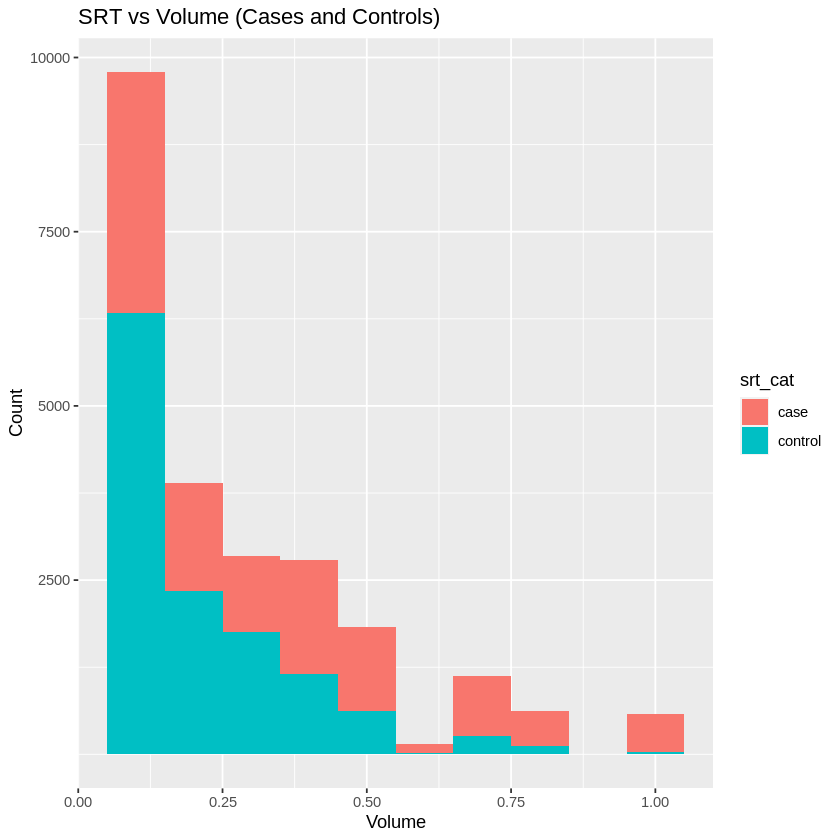

In [74]:
volume_srt <- srt_best_worst %>% 
  filter(!is.na(srt_cat)) %>% 
   ggplot(aes(x = mean,fill = srt_cat)) +
      geom_histogram(binwidth = 0.1) +
   labs(
    title = "SRT vs Volume (Cases and Controls)",
    x = "Volume",
    y = "Count"
    ) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500),
    labels = c("2500", "5000", "7500", "10000", "12500"))

volume_srt

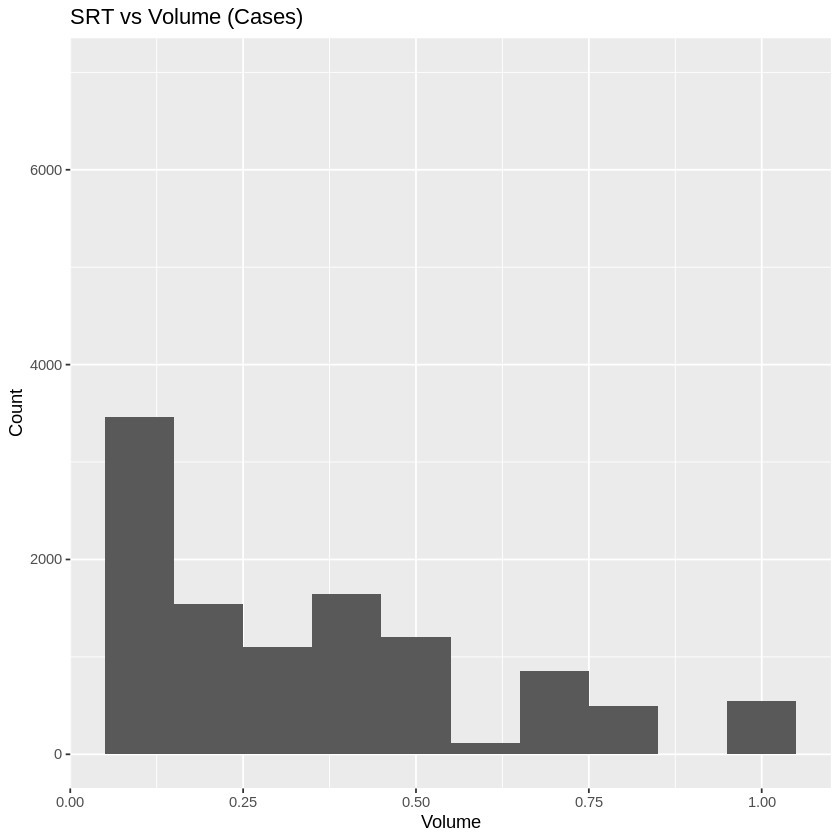

In [75]:
volume_case <- srt_best_worst %>% 
  filter(srt_cat == "case") %>% 
   ggplot(aes(x = mean)) +
      geom_histogram(binwidth = 0.1) +
   labs(
    title = "SRT vs Volume (Cases)",
    x = "Volume",
    y = "Count"
    ) + ylim(0,7000)

volume_case

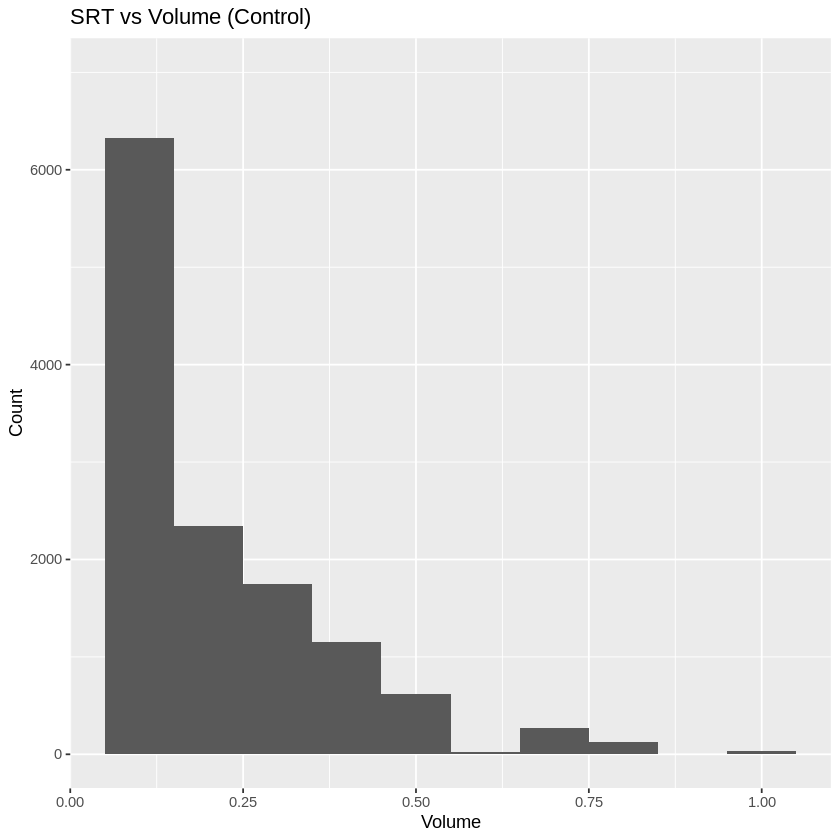

In [76]:
volume_control <- srt_best_worst %>% 
  filter(srt_cat == "control") %>% 
   ggplot(aes(x = mean)) +
      geom_histogram(binwidth = 0.1) +
   labs(
    title = "SRT vs Volume (Control)",
    x = "Volume",
    y = "Count"
    ) + ylim(0,7000)

volume_control

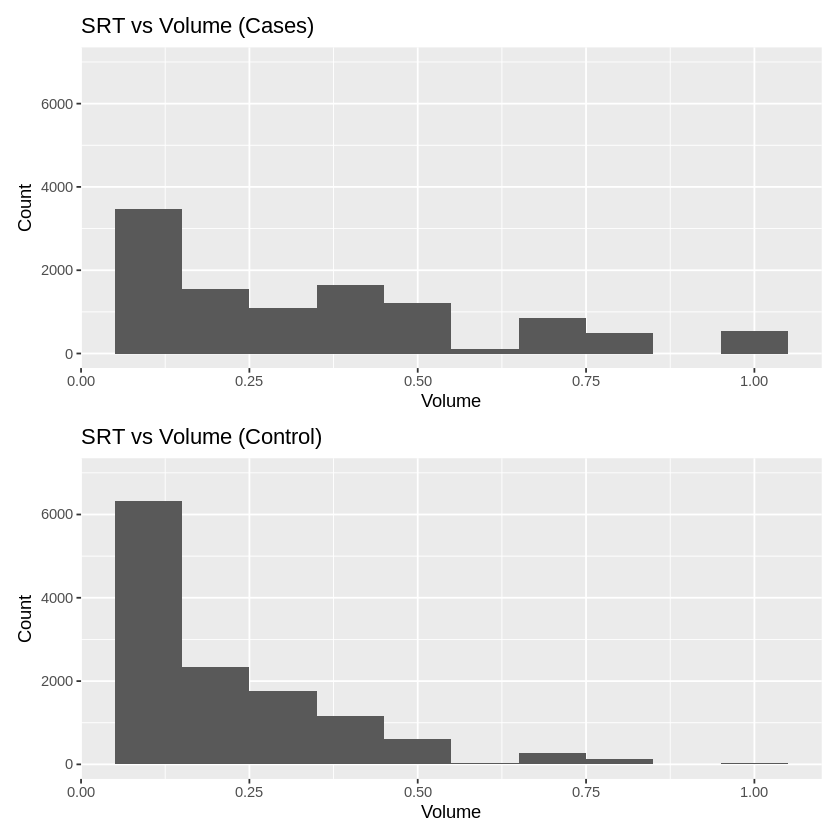

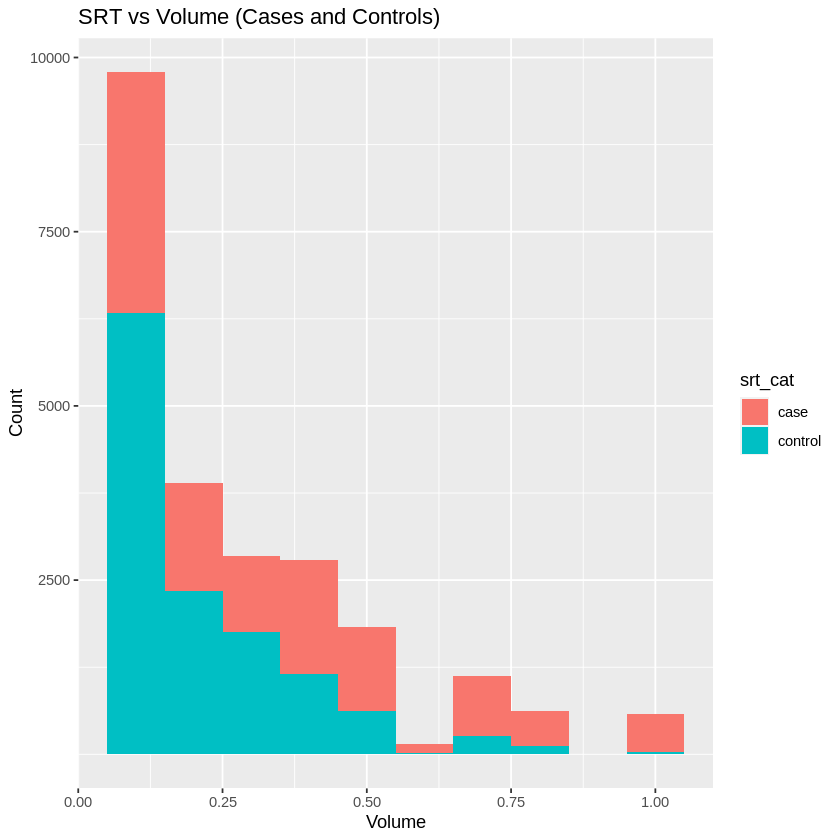

In [77]:
#install.packages("patchwork")
library(patchwork)
volume_case/ volume_control
volume_srt

## Plots

### Histograms SRT for right and left ear

In [78]:
#histogram for SRT Score for Left Ear
left_plot = srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(x = srt_score_left,fill = srt_left_cat)) +
      geom_histogram(binwidth = 0.25) +
   labs(
    title = "SRT Score for Left Ear (by category)",
    x = "SRT Score for Left ",
    y = "Count"
    ) +  
   scale_x_continuous(
    breaks = c(-11.25, -5.5, -3.5, 0.5)) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000"))
   scale_color_manual("SRT Score Category",labels = c("normal","insufficient","poor"), values = c("green", "red", "blue")) 

<ggproto object: Class ScaleDiscrete, Scale, gg>
    aesthetics: colour
    axis_order: function
    break_info: function
    break_positions: function
    breaks: waiver
    call: call
    clone: function
    dimension: function
    drop: TRUE
    expand: waiver
    get_breaks: function
    get_breaks_minor: function
    get_labels: function
    get_limits: function
    guide: legend
    is_discrete: function
    is_empty: function
    labels: normal insufficient poor
    limits: NULL
    make_sec_title: function
    make_title: function
    map: function
    map_df: function
    n.breaks.cache: NULL
    na.translate: TRUE
    na.value: NA
    name: SRT Score Category
    palette: function
    palette.cache: NULL
    position: left
    range: <ggproto object: Class RangeDiscrete, Range, gg>
        range: NULL
        reset: function
        train: function
        super:  <ggproto object: Class RangeDiscrete, Range, gg>
    rescale: function
    reset: function
    scale_name: manual

In [79]:
#histogram for SRT Score for Right Ear 
right_plot <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(x = srt_score_right, fill=srt_right_cat) ) +
      geom_histogram(binwidth =  0.25) +
  labs(
    title = "SRT Score for Right Ear (by category)",
    x = "SRT Score for Right ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-11.25, -5.5, -3.5, 0.5)) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
   scale_color_manual("SRT Score Category",labels = c("normal","insufficient","poor"), values = c("green", "red", "blue")) 

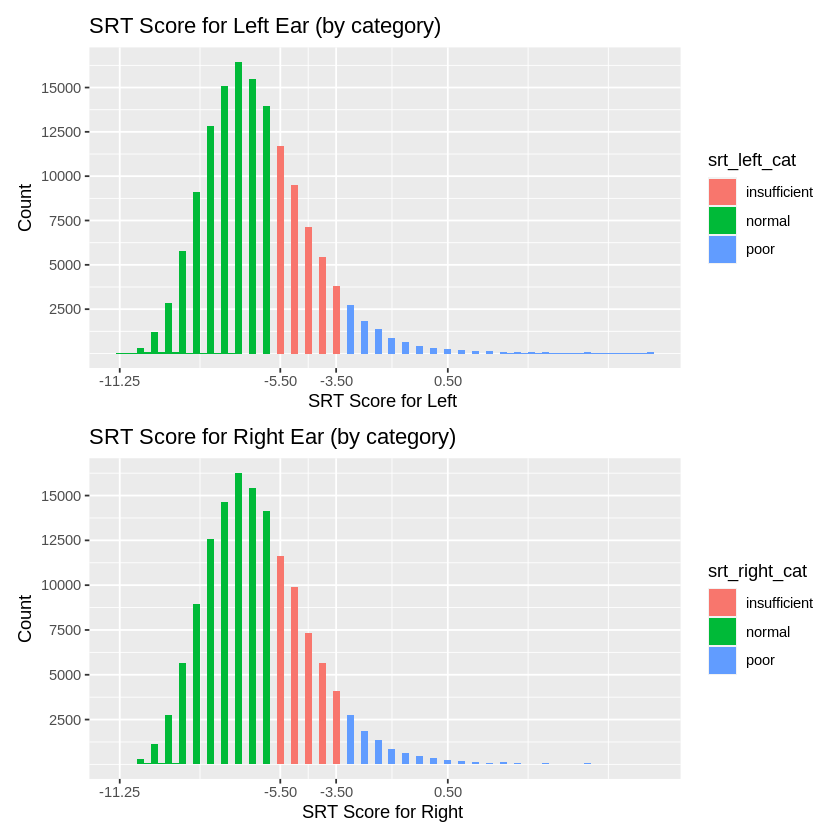

In [80]:
library(patchwork)
left_plot / right_plot

### Normality test for SRT

In [81]:
#install.packages("nortest")
library(nortest)
ad.test(srt_best_worst$srt_score_right)
ad.test(srt_best_worst$srt_score_left)
ad.test(srt_best_worst$best)
ad.test(srt_best_worst$worst)


	Anderson-Darling normality test

data:  srt_best_worst$srt_score_right
A = 1702, p-value < 2.2e-16



	Anderson-Darling normality test

data:  srt_best_worst$srt_score_left
A = 1822, p-value < 2.2e-16



	Anderson-Darling normality test

data:  srt_best_worst$best
A = 1516.6, p-value < 2.2e-16



	Anderson-Darling normality test

data:  srt_best_worst$worst
A = 2504.1, p-value < 2.2e-16


### QQ plots for right and left ear

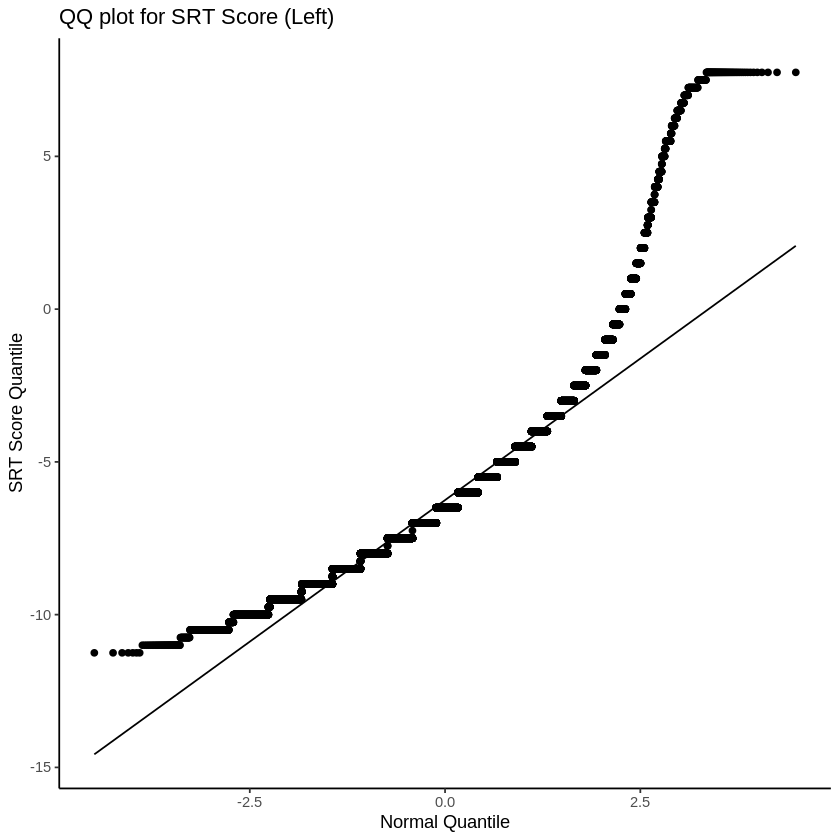

In [82]:
#QQ plot for SRT Score for Left Ear
qq_left_total <- srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(sample = (srt_score_left))) +
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Left)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_left_total

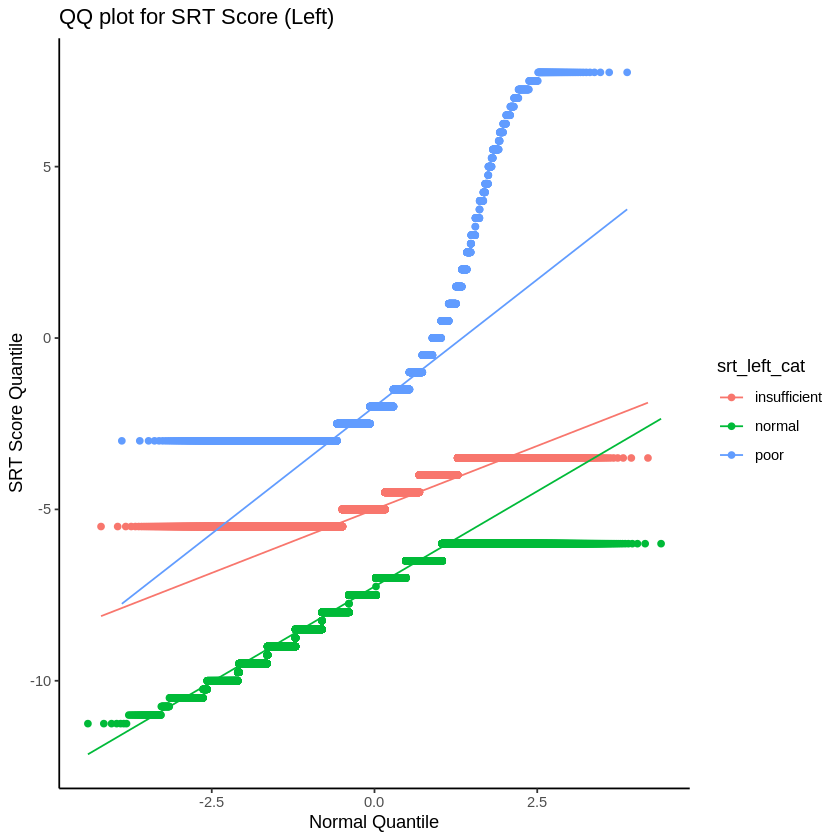

In [83]:
qq_left_by_cat <- srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(sample = srt_score_left, color = srt_left_cat)) +
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Left)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_left_by_cat

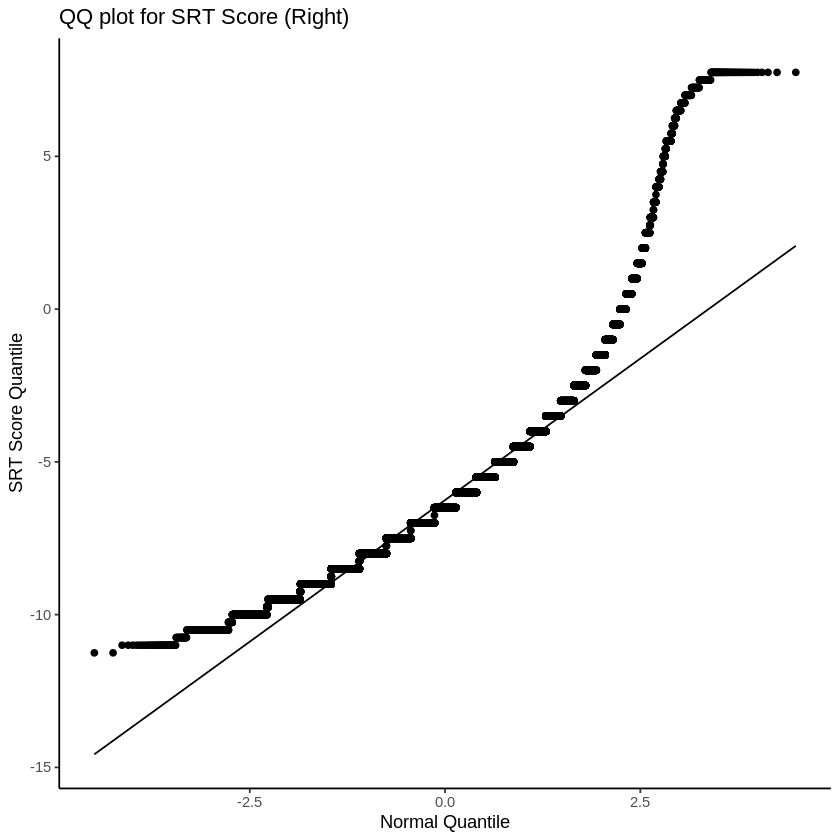

In [84]:
#QQ plot for SRT Score for Right Ear
qq_right_total <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(sample = srt_score_right)) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Right)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_right_total

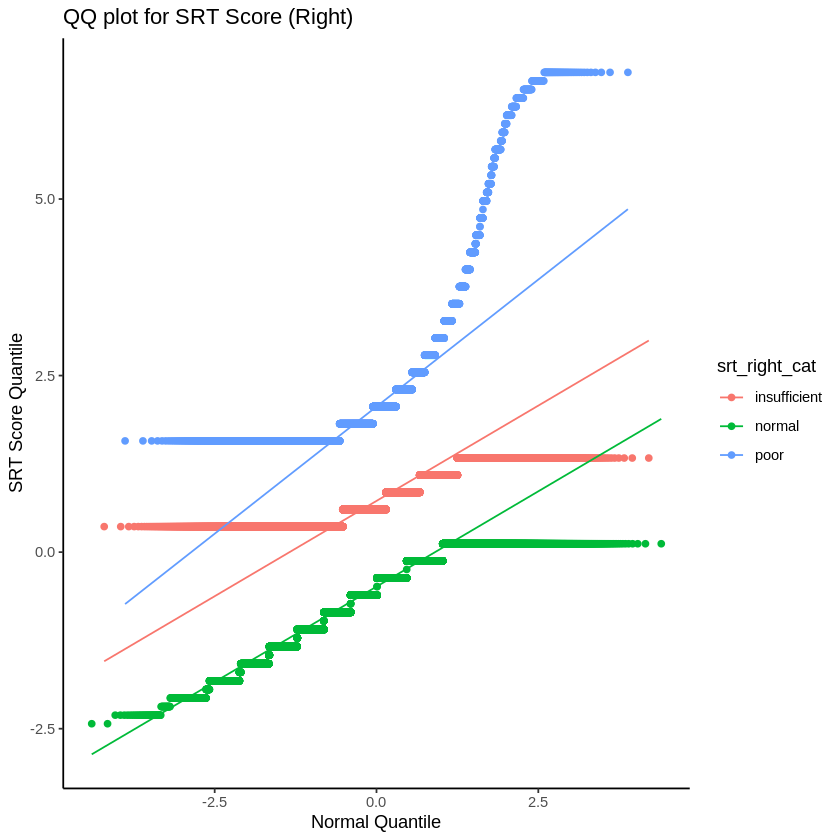

In [85]:
qq_right_by_cat <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(sample = (srt_score_right - mean(srt_score_right))/sd(srt_score_right), color = srt_right_cat)) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Right)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_right_by_cat

### Plots for best and worst ear

In [86]:
##Plots for Best and Worst Ear
srt_best_worst_cat <- srt_best_worst %>%
  mutate(srt_best_cat = case_when(
        best < -5.5   ~  "normal",
        -5.5 <= best & best <= -3.5   ~  "insufficient",
          best > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  mutate(srt_worst_cat = case_when(
        worst < -5.5   ~  "normal",
        -5.5 <= worst & worst <= -3.5   ~  "insufficient",
          worst > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  filter(!is.na(best) | !is.na(worst))

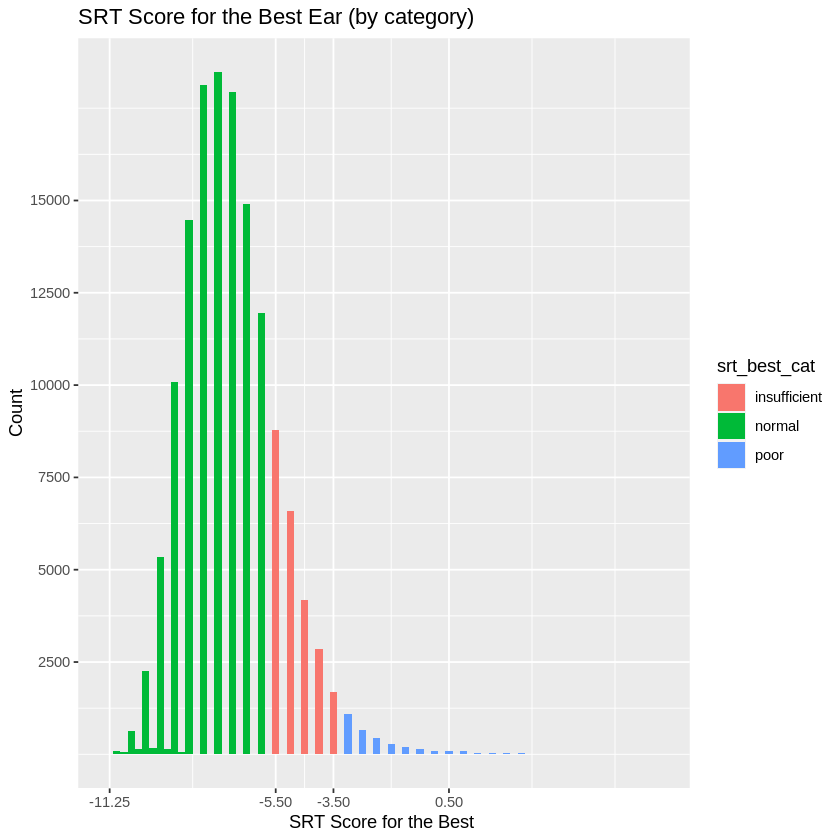

In [87]:
best_plot <- srt_best_worst_cat %>% 
  ggplot(aes(x = best, fill = srt_best_cat)) +
      geom_histogram(binwidth = 0.25) +
  labs(
    title = "SRT Score for the Best Ear (by category)",
    x = "SRT Score for the Best ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-11.25, -5.5, -3.5, 0.5)) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
   scale_color_manual("SRT Score Category",labels = c("normal","insufficient","poor"), values = c("green", "red", "blue")) 
best_plot

In [88]:
worst_plot <- srt_best_worst_cat %>% 
  ggplot(aes(x = worst, fill = srt_worst_cat)) +
      geom_histogram(binwidth = 0.25) +
  labs(
    title = "SRT Score for the Worst Ear (by category)",
    x = "SRT Score for the Worst ",
    y = "Count"
    ) + 
  scale_x_continuous(
    breaks = c(-11.25, -5.5, -3.5, 0.5)) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
   scale_color_manual("SRT Score Category",labels = c("normal","insufficient","poor"), values = c("green", "red", "blue")) 

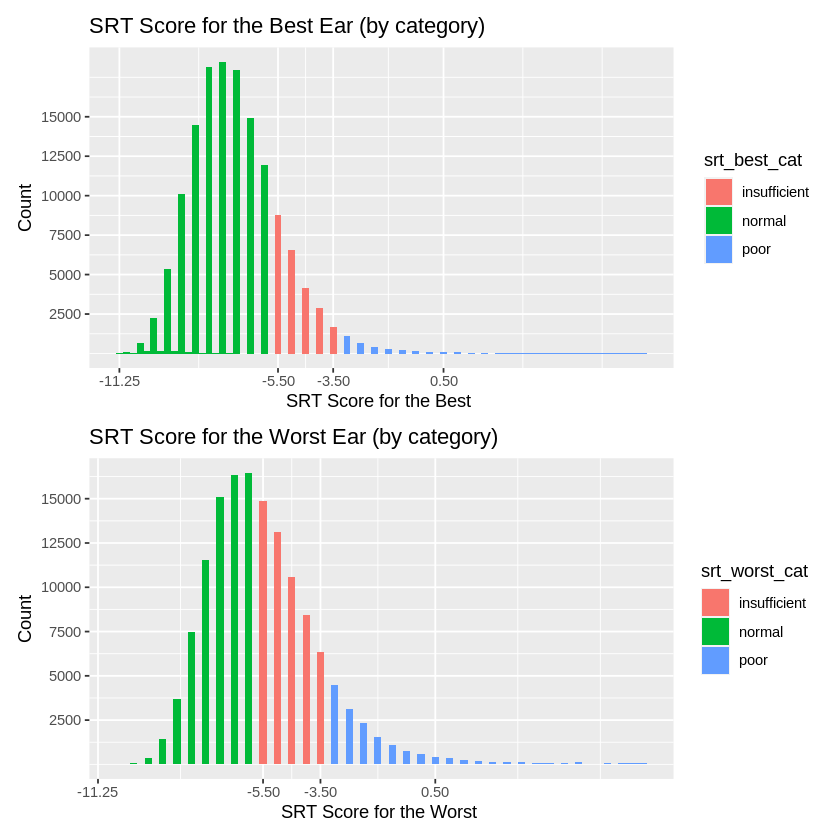

In [89]:
best_plot/worst_plot

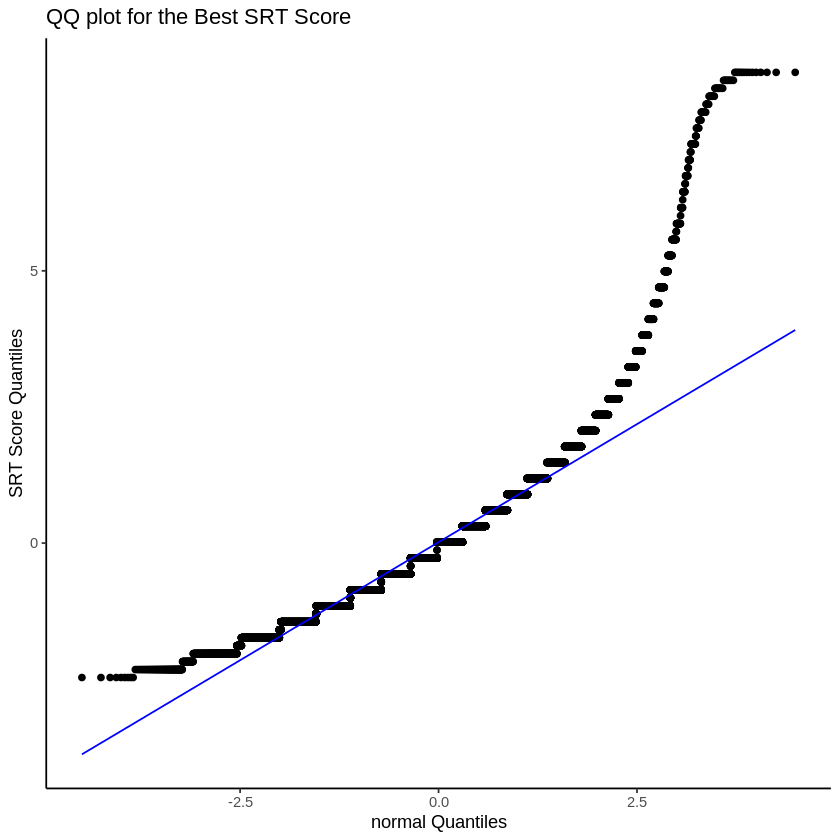

In [90]:
qq_best <- srt_best_worst_cat %>% 
  ggplot(aes(sample = (best - mean(best))/sd(best))) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line(col= 'blue') +
  labs(title="QQ plot for the Best SRT Score",
       y = "SRT Score Quantiles",
       x = "normal Quantiles") + 
theme_classic()  

qq_best

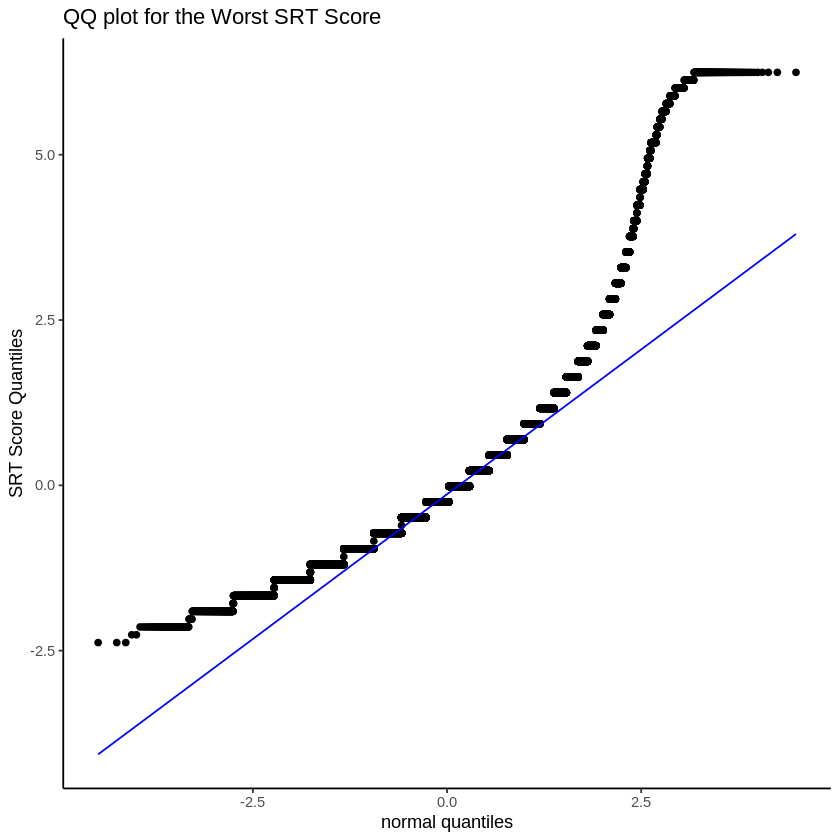

In [91]:
qq_worst <- srt_best_worst_cat %>% 
  ggplot(aes(sample = (worst - mean(worst))/sd(worst))) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line(col= 'blue') +
  labs(title="QQ plot for the Worst SRT Score",
       y = "SRT Score Quantiles",
       x = "normal quantiles") +
theme_classic()  

qq_worst

### Plots for inverse normalized trait

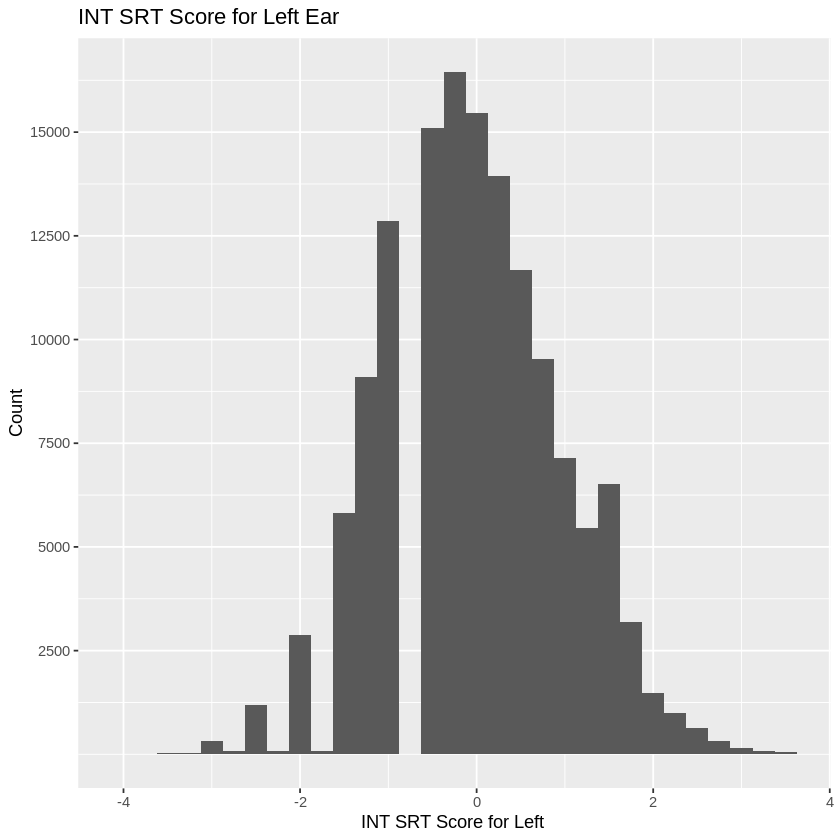

In [92]:
int_left_plot = srt_cc_left %>% 
  ggplot(aes(x = srt_int_left)) +
      geom_histogram(binwidth = 0.25) +
   labs(
    title = "INT SRT Score for Left Ear",
    x = "INT SRT Score for Left ",
    y = "Count"
    ) +  
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000"))
int_left_plot

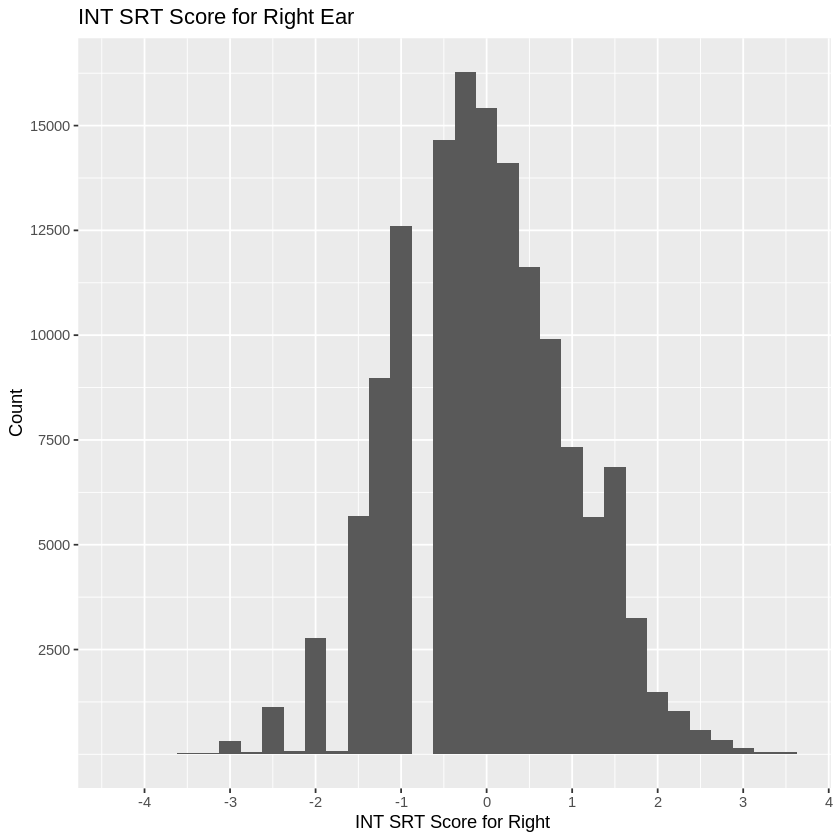

In [93]:
int_right_plot = srt_cc_right %>% 
  ggplot(aes(x = srt_int_right)) +
      geom_histogram(binwidth = 0.25) +
   labs(
    title = "INT SRT Score for Right Ear",
    x = "INT SRT Score for Right ",
    y = "Count"
    ) +  
scale_x_continuous(
    breaks= c(-4, -3, -2, -1, 0, 1, 2, 3, 4)) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000"))
int_right_plot

In [94]:
table(srt_cc_right$srt_int_right)


  -4.31445769885015   -3.61492432686373    -3.3685916548471   -2.94290733249114 
                  2                  38                  26                 325 
  -2.74720883366014   -2.44584980311471   -2.27322477830692   -2.02032390304535 
                 63                1124                  80                2780 
  -1.85431522620926   -1.62383481904029   -1.45788564476111   -1.25636433488817 
                 81                5645                  45                8971 
  -1.09640002681881  -0.910407378638475  -0.751732218644805  -0.588248649089633 
                 18               12597                   4               14643 
 -0.439216759369107  -0.284266868080542  -0.135900227145063 0.00204089218060126 
                  2               16269                   1               15430 
   0.26855380418517   0.517004143349072   0.752146056372439   0.975466898326404 
              14116               11636                9907                7339 
   1.18283930190574    1.37

In [95]:
table(srt_cat$srt_score_right)


-11.25    -11 -10.75  -10.5 -10.25    -10  -9.75   -9.5  -9.25     -9  -8.75 
     2     38     26    325     63   1124     80   2780     81   5645     45 
  -8.5  -8.25     -8  -7.75   -7.5  -7.25     -7  -6.75   -6.5     -6   -5.5 
  8971     18  12597      4  14643      2  16269      1  15430  14116  11636 
    -5   -4.5     -4   -3.5     -3   -2.5     -2   -1.5     -1   -0.5      0 
  9907   7339   5663   4080   2774   1889   1363    883    609    452    333 
   0.5      1    1.5      2    2.5   2.75      3   3.25    3.5   3.75      4 
   257    209    152     98    107     13     68      2     47      1     54 
  4.25    4.5   4.75      5   5.25    5.5   5.75      6   6.25    6.5   6.75 
    25     34      7     29     13     57     14     22     16     37     29 
     7   7.25    7.5   7.75 
    37     33     33     47 

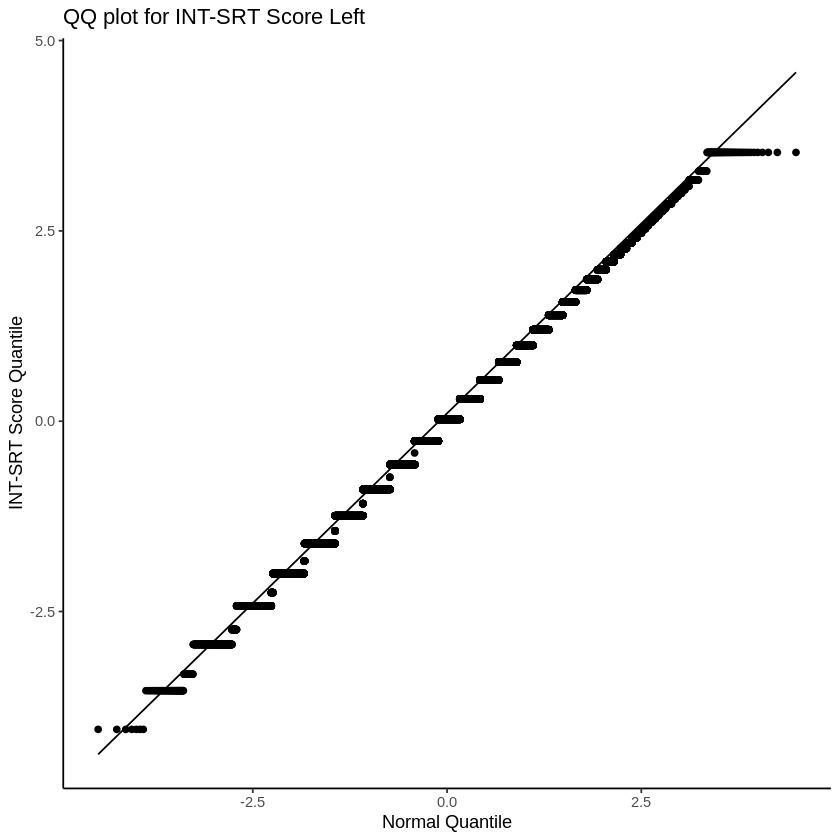

In [96]:
qq_left_int = ggplot(srt_cc_left,aes(sample=srt_int_left)) + 
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for INT-SRT Score Left",
       y = "INT-SRT Score Quantile",
       x = "Normal Quantile")+
  theme_classic()

qq_left_int

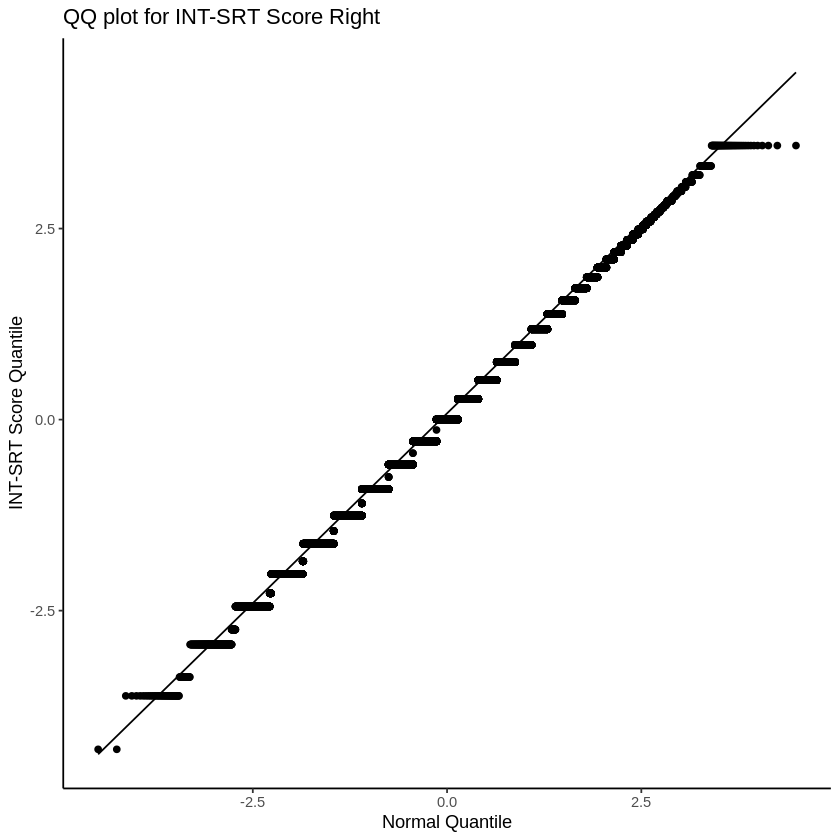

In [97]:
qq_right_int = ggplot(srt_cc_right,aes(sample=srt_int_right)) + 
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for INT-SRT Score Right",
       y = "INT-SRT Score Quantile",
       x = "Normal Quantile")+
  theme_classic()

qq_right_int

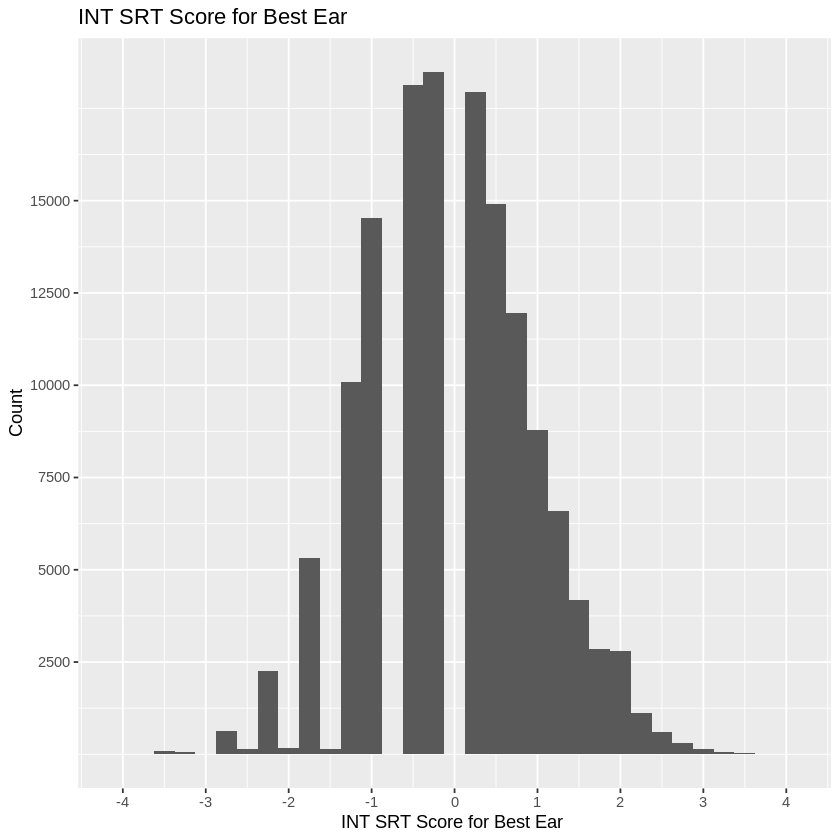

In [98]:
int_best_plot = srt_cc_best %>% 
  ggplot(aes(x = srt_int_best)) +
      geom_histogram(binwidth = 0.25) +
   labs(
    title = "INT SRT Score for Best Ear",
    x = "INT SRT Score for Best Ear ",
    y = "Count"
    ) +    
scale_x_continuous(
    breaks= c(-4, -3, -2, -1, 0, 1, 2, 3, 4)) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000"))
int_best_plot

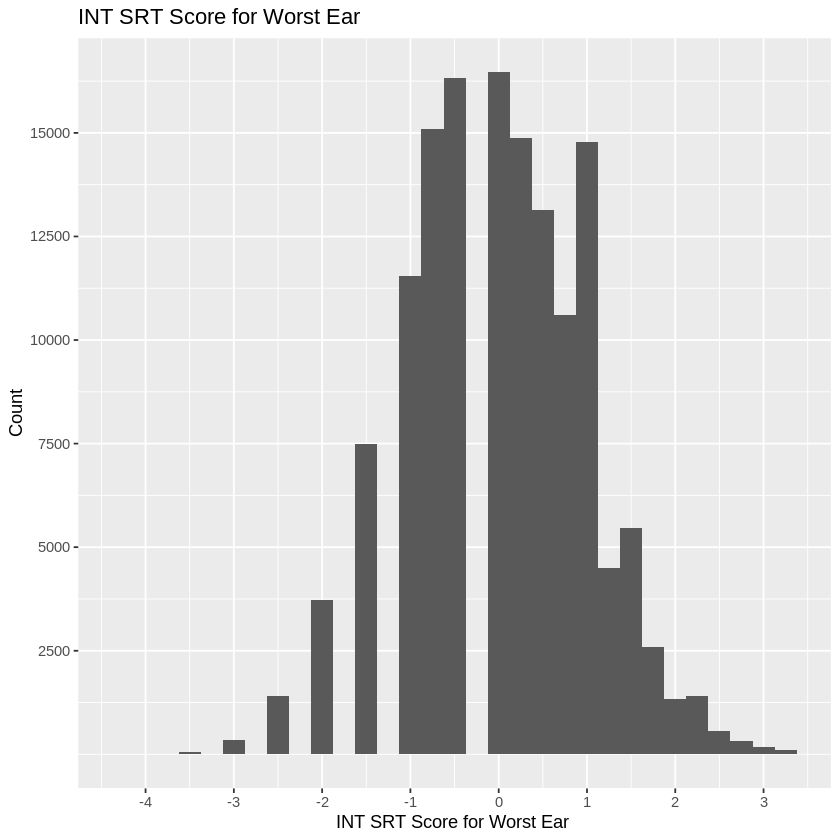

In [99]:
int_worst_plot = srt_cc_worst %>% 
  ggplot(aes(x = srt_int_worst)) +
      geom_histogram(binwidth = 0.25) +
   labs(
    title = "INT SRT Score for Worst Ear",
    x = "INT SRT Score for Worst Ear ",
    y = "Count"
    ) + 
  scale_x_continuous(
    breaks= c(-4, -3, -2, -1, 0, 1, 2, 3, 4)) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000"))
int_worst_plot

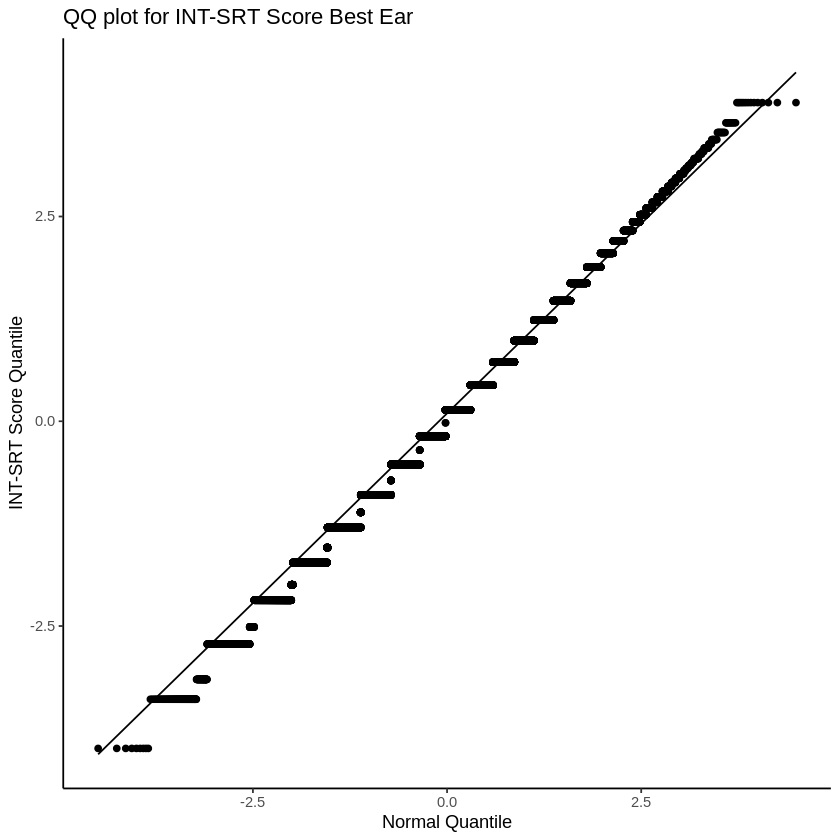

In [100]:
qq_best_int = ggplot(srt_cc_best,aes(sample=srt_int_best)) + 
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for INT-SRT Score Best Ear",
       y = "INT-SRT Score Quantile",
       x = "Normal Quantile")+
  theme_classic()

qq_best_int

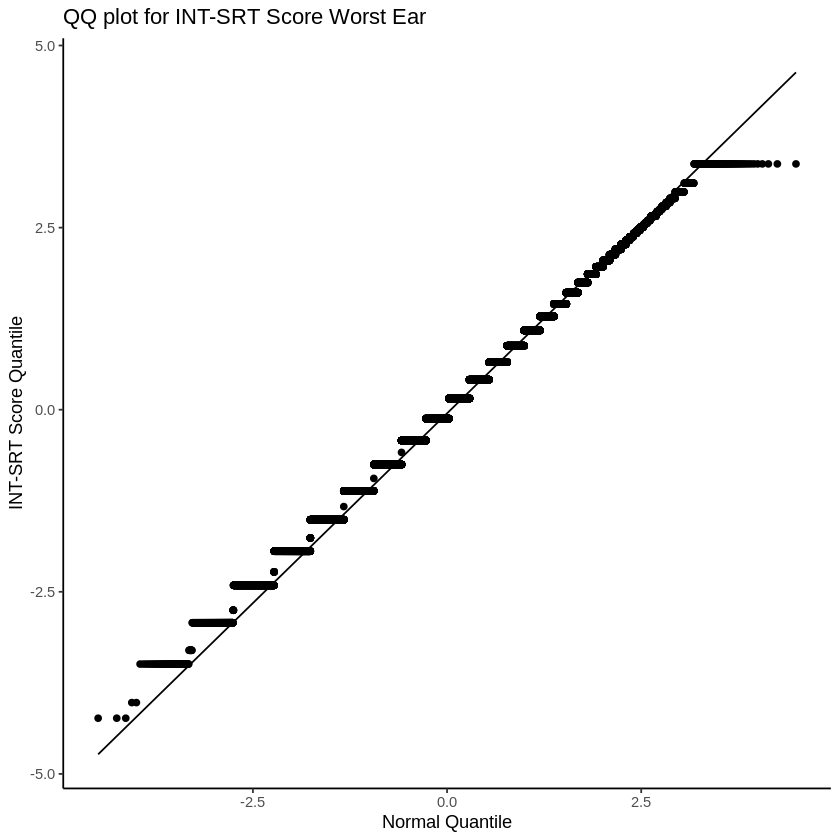

In [101]:
qq_worst_int = ggplot(srt_cc_worst,aes(sample=srt_int_worst)) + 
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for INT-SRT Score Worst Ear",
       y = "INT-SRT Score Quantile",
       x = "Normal Quantile")+
  theme_classic()

qq_worst_int

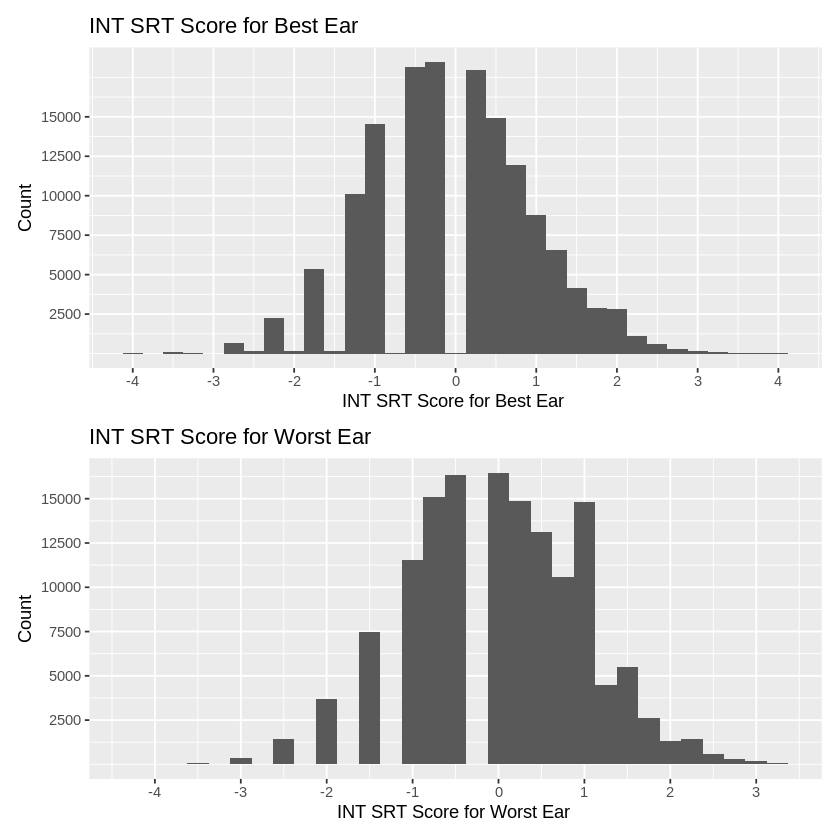

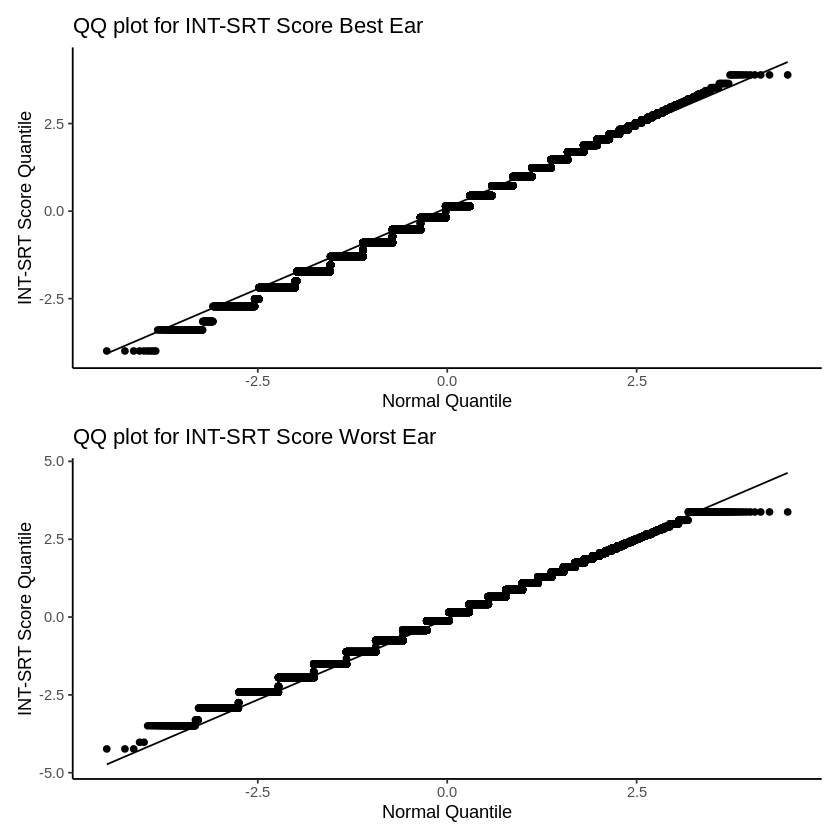

In [102]:
int_best_plot/int_worst_plot
qq_best_int/qq_worst_int

## Creation and export of phenotypic files

In [103]:
#Join all variables into one df
# Merge all of the variables in the final dataset
df.srt1 = merge(x = srt_best_worst,y = srt_cc_left[,c("IID", "srt_int_left")],by="IID", all.x=TRUE)
head(df.srt1)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,f.4836.3.0_recode,noise_wp,loud_music,srt_left_cat,srt_right_cat,best,worst,srt_cat,mean,srt_int_left
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<ord>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,NA,0,0,normal,insufficient,-6.0,-5.0,NA,0.55,0.29142764
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,NA,0,0,normal,normal,-8.5,-7.0,NA,0.70,-1.24228011
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,NA,0,0,insufficient,insufficient,-5.0,-4.0,NA,0.25,1.20159820
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,NA,0,0,normal,normal,-7.5,-6.5,NA,0.20,-0.56957764
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,NA,0,0,insufficient,insufficient,-4.0,-4.0,case,0.55,1.20159820
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,NA,0,0,normal,normal,-7.5,-6.5,NA,0.10,0.02530116


In [104]:
df.srt2 = merge(x = df.srt1,y = srt_cc_right[,c("IID", "srt_int_right")],by="IID", all.x=TRUE)
head(df.srt2)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,noise_wp,loud_music,srt_left_cat,srt_right_cat,best,worst,srt_cat,mean,srt_int_left,srt_int_right
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,0,0,normal,insufficient,-6.0,-5.0,NA,0.55,0.29142764,0.752146056
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,0,0,normal,normal,-8.5,-7.0,NA,0.70,-1.24228011,-0.284266868
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,0,0,insufficient,insufficient,-5.0,-4.0,NA,0.25,1.20159820,0.752146056
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,0,0,normal,normal,-7.5,-6.5,NA,0.20,-0.56957764,0.002040892
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,0,0,insufficient,insufficient,-4.0,-4.0,case,0.55,1.20159820,1.182839302
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,0,0,normal,normal,-7.5,-6.5,NA,0.10,0.02530116,-0.588248649


In [105]:
df.srt3 = merge(x = df.srt2,y = srt_cc_best[,c("IID", "srt_int_best")],by="IID", all.x=TRUE)
head(df.srt3)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,loud_music,srt_left_cat,srt_right_cat,best,worst,srt_cat,mean,srt_int_left,srt_int_right,srt_int_best
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,0,normal,insufficient,-6.0,-5.0,NA,0.55,0.29142764,0.752146056,0.7217378
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,0,normal,normal,-8.5,-7.0,NA,0.70,-1.24228011,-0.284266868,-0.8999203
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,0,insufficient,insufficient,-5.0,-4.0,NA,0.25,1.20159820,0.752146056,1.2350009
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,0,normal,normal,-7.5,-6.5,NA,0.20,-0.56957764,0.002040892,-0.1832491
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,0,insufficient,insufficient,-4.0,-4.0,case,0.55,1.20159820,1.182839302,1.6853148
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,0,normal,normal,-7.5,-6.5,NA,0.10,0.02530116,-0.588248649,-0.1832491


In [106]:
df.final.srt = merge(x = df.srt3,y = srt_cc_worst[,c("IID", "srt_int_worst")],by="IID", all.x=TRUE)
head(df.final.srt)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,srt_left_cat,srt_right_cat,best,worst,srt_cat,mean,srt_int_left,srt_int_right,srt_int_best,srt_int_worst
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,normal,insufficient,-6.0,-5.0,NA,0.55,0.29142764,0.752146056,0.7217378,0.4118874
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,normal,normal,-8.5,-7.0,NA,0.70,-1.24228011,-0.284266868,-0.8999203,-0.7526265
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,insufficient,insufficient,-5.0,-4.0,NA,0.25,1.20159820,0.752146056,1.2350009,0.8776937
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,normal,normal,-7.5,-6.5,NA,0.20,-0.56957764,0.002040892,-0.1832491,-0.4227974
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,insufficient,insufficient,-4.0,-4.0,case,0.55,1.20159820,1.182839302,1.6853148,0.8776937
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,normal,normal,-7.5,-6.5,NA,0.10,0.02530116,-0.588248649,-0.1832491,-0.4227974


In [107]:
df.final.srt$sex <- revalue(df.final.srt$f.22001.0.0, c("Male" = '0', 'Female'='1' ))
df.final.srt$srt_cat <- revalue(df.final.srt$srt_cat, c("control" = '0', 'case'='1' ))
names(df.final.srt)[names(df.final.srt) == "srt_age"] <- "age"
names(df.final.srt)[names(df.final.srt) == "mean"] <- "volume_mean"
table(df.final.srt$sex)
dim(df.final.srt)


    1     0 
76299 66076 

[1] 142375     57

In [129]:
# Last renaming and recoding
srt_pheno <- df.final.srt %>%
 select(FID, IID, age, sex, srt_int_left, srt_int_right, srt_int_best, srt_int_worst, srt_cat, volume_mean, left_volume, right_volume, noise_wp, loud_music)
head(srt_pheno)
dim(srt_pheno)

,FID,IID,age,sex,srt_int_left,srt_int_right,srt_int_best,srt_int_worst,srt_cat,volume_mean,left_volume,right_volume,noise_wp,loud_music
,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,73,1,0.29142764,0.752146056,0.7217378,0.4118874,NA,0.55,0.7,0.4,0,0
2,1000063,1000063,43,0,-1.24228011,-0.284266868,-0.8999203,-0.7526265,NA,0.70,0.4,1.0,0,0
3,1000078,1000078,60,1,1.20159820,0.752146056,1.2350009,0.8776937,NA,0.25,0.4,0.1,0,0
4,1000105,1000105,54,1,-0.56957764,0.002040892,-0.1832491,-0.4227974,NA,0.20,0.2,0.2,0,0
5,1000112,1000112,68,0,1.20159820,1.182839302,1.6853148,0.8776937,1,0.55,0.7,0.4,0,0
6,1000141,1000141,49,1,0.02530116,-0.588248649,-0.1832491,-0.4227974,NA,0.10,0.1,0.1,0,0


[1] 142375     14

In [130]:
length(which(is.na(srt_pheno$noise_wp)))

[1] 2365

In [131]:
length(which(is.na(srt_pheno$loud_music)))

[1] 3056

In [137]:
srt_int_left_cc <- srt_pheno %>%
  filter (!is.na(srt_int_left) & !(is.na(volume_mean)) & !(is.na(noise_wp)) & !(is.na(loud_music))) %>%
  select(FID, IID, age, sex, srt_int_left, left_volume, noise_wp, loud_music) %>%
  mutate(left_volume_int = apply(select(., starts_with("left_volume")), 1, function(x) (x*10)))
dim(srt_int_left_cc)
head(srt_int_left_cc, 20)
write.table(srt_int_left_cc, '200904_UKBB_SRT_int_left_cc', quote = FALSE, row.names = FALSE)

[1] 134908      9

,FID,IID,age,sex,srt_int_left,left_volume,noise_wp,loud_music,left_volume_int
,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,73,1,0.29142764,0.7,0,0,7
2,1000063,1000063,43,0,-1.24228011,0.4,0,0,4
3,1000078,1000078,60,1,1.20159820,0.4,0,0,4
4,1000105,1000105,54,1,-0.56957764,0.2,0,0,2
5,1000112,1000112,68,0,1.20159820,0.7,0,0,7
6,1000141,1000141,49,1,0.02530116,0.1,0,0,1
7,1000236,1000236,70,0,-1.24228011,0.2,0,0,2
8,1000269,1000269,71,0,0.99625472,0.2,0,0,2
9,1000357,1000357,69,1,0.02530116,0.4,0,0,4


In [138]:
srt_int_right_cc <- srt_pheno %>%
  filter (!is.na(srt_int_right) & !(is.na(volume_mean)) & !(is.na(noise_wp)) & !(is.na(loud_music))) %>%
  select(FID, IID, age, sex, srt_int_right, right_volume, noise_wp, loud_music) %>%
  mutate(right_volume_int = apply(select(., starts_with("right_volume")), 1, function(x) (x*10)))
dim(srt_int_right_cc)
head(srt_int_right_cc)
write.table(srt_int_right_cc, '200904_UKBB_SRT_int_right_cc', quote = FALSE, row.names = FALSE)

[1] 134865      9

,FID,IID,age,sex,srt_int_right,right_volume,noise_wp,loud_music,right_volume_int
,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,73,1,0.752146056,0.4,0,0,4
2,1000063,1000063,43,0,-0.284266868,1.0,0,0,10
3,1000078,1000078,60,1,0.752146056,0.1,0,0,1
4,1000105,1000105,54,1,0.002040892,0.2,0,0,2
5,1000112,1000112,68,0,1.182839302,0.4,0,0,4
6,1000141,1000141,49,1,-0.588248649,0.1,0,0,1


In [139]:
srt_int_best_cc <- srt_pheno %>%
  filter (!is.na(srt_int_best) & !(is.na(volume_mean)) & !(is.na(noise_wp)) & !(is.na(loud_music))) %>%
  select(FID, IID, age, sex, srt_int_best, volume_mean, noise_wp, loud_music)
dim(srt_int_best_cc)
head(srt_int_best_cc)
write.table(srt_int_best_cc, '200904_UKBB_SRT_int_best_cc', quote = FALSE, row.names = FALSE)

[1] 135829      8

,FID,IID,age,sex,srt_int_best,volume_mean,noise_wp,loud_music
,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,73,1,0.7217378,0.55,0,0
2,1000063,1000063,43,0,-0.8999203,0.70,0,0
3,1000078,1000078,60,1,1.2350009,0.25,0,0
4,1000105,1000105,54,1,-0.1832491,0.20,0,0
5,1000112,1000112,68,0,1.6853148,0.55,0,0
6,1000141,1000141,49,1,-0.1832491,0.10,0,0


In [140]:
srt_int_worst_cc <- srt_pheno %>%
  filter (!is.na(srt_int_worst) & !(is.na(volume_mean)) & !(is.na(noise_wp)) & !(is.na(loud_music))) %>%
  select(FID, IID, age, sex, srt_int_worst, volume_mean, noise_wp, loud_music)
dim(srt_int_worst_cc)
head(srt_int_worst_cc)
write.table(srt_int_worst_cc, '200904_UKBB_SRT_int_worst_cc', quote = FALSE, row.names = FALSE)

[1] 135829      8

,FID,IID,age,sex,srt_int_worst,volume_mean,noise_wp,loud_music
,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,73,1,0.4118874,0.55,0,0
2,1000063,1000063,43,0,-0.7526265,0.70,0,0
3,1000078,1000078,60,1,0.8776937,0.25,0,0
4,1000105,1000105,54,1,-0.4227974,0.20,0,0
5,1000112,1000112,68,0,0.8776937,0.55,0,0
6,1000141,1000141,49,1,-0.4227974,0.10,0,0


In [141]:
srt_cat_cc <- srt_pheno %>%
  filter (!is.na(srt_cat) & !(is.na(volume_mean)) & !(is.na(noise_wp)) & !(is.na(loud_music))) %>%
  select(FID, IID, age, sex, srt_cat, volume_mean, noise_wp, loud_music)
dim(srt_cat_cc)
head(srt_cat_cc)
write.table(srt_cat_cc, '200904_UKBB_SRT_cat_cc', quote = FALSE, row.names = FALSE)

[1] 22789     8

,FID,IID,age,sex,srt_cat,volume_mean,noise_wp,loud_music
,<int>,<int>,<int>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
1,1000112,1000112,68,0,1,0.55,0,0
2,1000421,1000421,64,1,0,0.15,0,0
3,1000683,1000683,68,0,0,0.10,0,0
4,1000728,1000728,61,0,0,0.10,0,0
5,1001067,1001067,50,0,1,0.40,0,0
6,1001080,1001080,62,1,0,0.55,0,0


In [226]:
write.table(srt_pheno, '200819_UKBB_SRT_f20019&f.20021', quote = FALSE, row.names = FALSE)

In [124]:
pheno = read.table('200819_UKBB_SRT_f20019_f20021', header=TRUE)

In [125]:
head(pheno)

,FID,IID,age,sex,srt_int_left,srt_int_right,srt_int_best,srt_int_worst,srt_cat,volume_mean,noise_imp,music_imp
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>
1,1000046,1000046,73,1,0.29142764,0.752146056,0.7217378,0.4118874,NA,0.55,0,0
2,1000063,1000063,43,0,-1.24228011,-0.284266868,-0.8999203,-0.7526265,NA,0.70,0,0
3,1000078,1000078,60,1,1.20159820,0.752146056,1.2350009,0.8776937,NA,0.25,0,0
4,1000105,1000105,54,1,-0.56957764,0.002040892,-0.1832491,-0.4227974,NA,0.20,0,0
5,1000112,1000112,68,0,1.20159820,1.182839302,1.6853148,0.8776937,1,0.55,0,0
6,1000141,1000141,49,1,0.02530116,-0.588248649,-0.1832491,-0.4227974,NA,0.10,0,0


In [127]:
length(which(!(is.na(pheno$srt_int_left))))

[1] 140647

In [9]:
length(which(is.na(pheno$noise_imp)))

[1] 3809

In [10]:
length(which(is.na(pheno$music_imp)))

[1] 3809

In [11]:
srt_int_left <- pheno %>%
 filter(!is.na(srt_int_left)) %>%
 select(FID, IID, age, sex, srt_int_left, volume_mean, noise_imp, music_imp)
head(srt_int_left)

,FID,IID,age,sex,srt_int_left,volume_mean,noise_imp,music_imp
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,1000046,1000046,73,1,0.29142764,0.55,0,0
2,1000063,1000063,43,0,-1.24228011,0.70,0,0
3,1000078,1000078,60,1,1.20159820,0.25,0,0
4,1000105,1000105,54,1,-0.56957764,0.20,0,0
5,1000112,1000112,68,0,1.20159820,0.55,0,0
6,1000141,1000141,49,1,0.02530116,0.10,0,0


In [14]:
length(which(is.na(srt_int_left$music_imp)))

[1] 3769